In [1]:
from functools import reduce
import numpy as np

In [2]:
import tarjan
tarjan = tarjan.tarjan

In [4]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
import matplotlib.patches as patches
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        'alpha':0.6
        }

colors = ["red", "blue", "green","purple","purple","yellow","brown","black","gray","pink","orange"]


In [6]:
import pandas as pd

links = pd.read_csv("C:\\Users\\Vipul Satone\\IGL\\data/links.csv")
nodes = pd.read_csv("C:\\Users\\Vipul Satone\\IGL\\data/nodes.csv")
full_links = pd.read_csv("C:\\Users\\Vipul Satone\\IGL\\data/full_link_ids.csv")
full_links = [int(link) for link in full_links]

In [7]:
import json
with open('C:\\Users\\Vipul Satone\\IGL\\data\\full_link_travel_times.json') as json_data:
    d = json.load(json_data)
d = np.array(d)

In [8]:
good_links = links[links['link_id'].isin(full_links)]

In [9]:
upperLeft = np.array([40.770496, -73.991334])
upperRight = np.array([40.758451, -73.962862])
lowerRight = np.array([40.743464, -73.973467])
lowerLeft = np.array([40.756895, -74.004889])

In [10]:
class Edge:
    def __init__(self, idx, startNodeId, endNodeId, length):
        self.idx = idx
        self.start = startNodeId
        self.end = endNodeId
        self.length = length
        
    def setTime(self, times):
        self.times = times
        
    def getSpeed(self):
        return self.length / self.times
    
    def getSpeedAt(self, day, hour):
        return self.length / self.times[24*day + hour]
    
    def __str__(self):
        return "{},{},{},{}".format(self.idx, self.start, self.end, self.length)
    
    def __repr__(self):
        return self.__str__()
    
class Node:
    def __init__(self, idx, x, y):
        self.idx = idx
        self.x = x
        self.y = y    
        
    def __str__(self):
        return "{},{}".format(self.x, self.y)
    
    def __repr__(self):
        return self.__str__()

class Graph:
    
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.out = {}
        
    def add_edge(self, link):
        new_edge = Edge(link['link_id'], link['begin_node_id'],
                        link['end_node_id'], link['street_length'])
        self.nodes[link['begin_node_id']] = Node(link['begin_node_id'],
                                            link['startX'], link['startY'])
        self.nodes[link['end_node_id']] = Node(link['end_node_id'],
                                            link['endX'], link['endY'])
        if link['begin_node_id'] not in self.out:
            self.out[link['begin_node_id']] = []
        self.out[link['begin_node_id']].append(new_edge)
        self.edges[link['link_id']] = new_edge
        
    def filterEdges(self, func):
        return [self.edges[k] for k in self.edges if func(self.edges[k])]
    
    def filterNodes(self, func):
        return [self.nodes[k] for k in self.nodes if func(self.nodes[k])]
    
    def getEdgeCoords(self, edges):
        return [[[self.nodes[e.start].y,self.nodes[e.start].x],
          [self.nodes[e.end].y,self.nodes[e.end].x]] for e in edges]
    
    def drawEdges(self, m, edges,colors,cIdx):
        for loc in self.getEdgeCoords(edges):
            m.add_child(PolyLine(locations=loc,color= colors[cIdx%len(colors)] ))
            
    def subgraph(self, edges):
        newg = Graph()
        #newg.edges = edges
        newg.edges = {e.idx: e for e in edges}
        #print(newg.edges)
        #for k, e in edges.items():
        for e in edges:
            #print(e)
            newg.nodes[e.start] = self.nodes[e.start]
            newg.nodes[e.end] = self.nodes[e.end]
            if e.start not in newg.out:
                newg.out[e.start] = []
            newg.out[e.start].append(e)
        return newg
    
    def _getEdgesFromScc(self, scc):
        cset = {}
        for i, c in enumerate(scc):
            for n in c:
                cset[n] = i
        eset = {}
        for k,e in self.edges.items():
            if cset[e.start] == cset[e.end]:
                if cset[e.start] not in eset:
                    eset[cset[e.start]] = []
                eset[cset[e.start]].append(e)
            
        edges_to_draw = list(eset.values())
        return edges_to_draw
    
    def scc(self):
        scs = tarjan({k:[e.end for e in self.out[k]] for k in self.out})
        return self._getEdgesFromScc(scs)
    
    def sccNode(self):
        scs = tarjan({k:[e.end for e in self.out[k]] for k in self.out})
        return scs
    
    def cc(self):
        d = {}
        #for k,e in enumerate(self.edges):
        #print("cc e = ",self.edges)
        for k,e in self.edges.items():
            #print("e = ", e)
            #print("k=", k)
            
            if e.start not in d:
                d[e.start] = set()
            if e.end not in d:
                d[e.end] = set()
            d[e.start].add(e.end)
            d[e.end].add(e.start)
        cs = tarjan({k: list(d[k]) for k in d})
        return self._getEdgesFromScc(cs)
    
    def ccNode(self):
        d = {}
        for k,e in self.edges.items():
            if e.start not in d:
                d[e.start] = set()
            if e.end not in d:
                d[e.end] = set()
            d[e.start].add(e.end)
            d[e.end].add(e.start)
        cs = tarjan({k: list(d[k]) for k in d})
        return cs
    
    def getSubArea(self, upperLeft, upperRight, lowerLeft, lowerRight):
        qualified_edges = []
        #for k,e in self.edges.items():
        #    if upperRight[0]< self.nodes[e.start].y<upperLeft[0] and \
        #    lowerRight[0]< self.nodes[e.start].y<lowerLeft[0] and \
        #    upperLeft[1]< self.nodes[e.start].x<lowerLeft[1] and \
        #    upperRight[1]< self.nodes[e.start].x<lowerRight[1]:
        #        qualified_edges.append(e)
        for k,e in self.edges.items():
            temp1 = np.cross(np.array([self.nodes[e.start].y,self.nodes[e.start].x])-upperLeft,upperRight - upperLeft)
            temp2 = np.cross(np.array([self.nodes[e.start].y,self.nodes[e.start].x])-upperRight,lowerRight - upperRight)
            temp3 = np.cross(np.array([self.nodes[e.start].y,self.nodes[e.start].x])-lowerRight,lowerLeft - lowerRight)
            temp4 = np.cross(np.array([self.nodes[e.start].y,self.nodes[e.start].x])-lowerLeft, upperLeft - lowerLeft)
            start = [temp1, temp2, temp3, temp4]
            temp5 = np.cross(np.array([self.nodes[e.end].y,self.nodes[e.end].x])-upperLeft,upperRight - upperLeft)
            temp6 = np.cross(np.array([self.nodes[e.end].y,self.nodes[e.end].x])-upperRight,lowerRight - upperRight)
            temp7 = np.cross(np.array([self.nodes[e.end].y,self.nodes[e.end].x])-lowerRight,lowerLeft - lowerRight)
            temp8 = np.cross(np.array([self.nodes[e.end].y,self.nodes[e.end].x])-lowerLeft, upperLeft - lowerLeft)
            end = [temp5, temp6, temp7, temp8]
            #folium.Marker(
            #    location=[self.nodes[e.start].y,self.nodes[e.start].x],
            #    popup='{}'.format(k),
            #    icon=folium.Icon(icon='cloud')
            #).add_to(m)
            if all(i < 0 for i in start) or all(i < 0 for i in end): 
                qualified_edges.append(e)
        return qualified_edges
        
        
        

In [11]:
g = Graph()
for i, l in good_links.iterrows():
    g.add_edge(l)
    

In [12]:
idxToId = list(good_links['link_id'])
for i, idx in enumerate(idxToId):
    g.edges[idx].setTime(d[:,i])
speeds = np.array([g.edges[k].getSpeed() for k in g.edges])

In [13]:
#qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, 3) < 11)
qualify_area = g.getSubArea(upperLeft, upperRight, lowerLeft, lowerRight)
#g.drawEdges(m,qualify_area,colors,1)
idLists = [e.idx for e in qualify_area]
sub_g_e = good_links[good_links['link_id'].isin(idLists)]
#links[links['link_id'].isin(full_links)]
block_g = Graph()
for i,l in sub_g_e.iterrows():
    block_g.add_edge(l)
idxToId = list(sub_g_e['link_id'])
for i, idx in enumerate(idxToId):
    block_g.edges[idx].setTime(d[:,i])

In [14]:

def DrawBarcode(CompLists, thresholds,t, ctype):
    liveOrder = []
    MaxOrder = 0
    Link_to_Order = {}
    #comp_dic = {}
    for i in range(len(thresholds)):
        curComps = CompLists[i]
        if i == 0:
            for j in range(len(curComps)):
                #comp_dic[j] = []
                for link in curComps[j]:
                    Link_to_Order[link] = j
                    #comp_dic[j].append(link)
            MaxOrder = len(curComps)-1
#            print("first MaxOrder = " + str(MaxOrder))
            liveOrder = liveOrder + [list(range(len(curComps)))]
        else:
            tempLiveOrder = []
            for j in range(len(curComps)):
                tempLinks = []
                tempOrder = []
                for link in curComps[j]:
                    if link in Link_to_Order:
                        tempOrder.append(Link_to_Order[link])
                    else:
                        tempOrder.append(MaxOrder+1)
                    tempLinks.append(link)
                newOrder = min(tempOrder)
                for clink in tempLinks:
                    Link_to_Order[clink] = newOrder
                if newOrder > MaxOrder:
                    MaxOrder = newOrder
                tempLiveOrder.append(newOrder)
            liveOrder = liveOrder + [tempLiveOrder]  
    print("Max order" + str(MaxOrder))

    liveTime = []
    begins = []
    for i in range(MaxOrder):
        c = 0
#        print("i = " + str(i))
        for j in range(len(liveOrder)):
            if i in liveOrder[j]:
                if c == 0:
                    begins.append(j)
#                    print("j = " + str(j))
                c = c+1               
        liveTime.append(c)

    begin = np.array(begins)
    end = np.array(begin) + np.array(liveTime)
    fig1 = plt.figure(figsize=(8, 8), dpi=100)
    plt.xlabel('Speed criteria(<=)')
    plt.ylabel('Components Emergence Order')
    plt.text(0, MaxOrder + 80, 'Current Time: 2011 - 01 - 01 - {}:00'.format(str(t)), fontdict=font)
    #plt.text(1, 2000, 'Current Time: 2011 - 01 - 01 - {}:00'.format(str(t)), fontdict=font, bbox=dict(facecolor='grey', alpha=0.1))
    ax1 = fig1.add_subplot(111)
    for i, b, e in zip(range(len(begin)), begin, end):
        ax1.add_patch(
            patches.Rectangle((b, i), e-b, 1, edgecolor = "none")
        )
    ax1.set_xlim([0, len(thresholds)+1])
    #ax1.set_ylim([0, 500])
    ax1.set_ylim([0, MaxOrder + 100])
    plt.title('Barplots of Strongly Connected Components')
    #plt.savefig('./barplot/tmp_scc_{}.png'.format(str(t)))


    return MaxOrder, liveTime, Link_to_Order
                
            
    
    

Max order380
Max order384
Max order377
Max order382
Max order377
Max order379
Max order371
Max order365
Max order365
Max order369
Max order374
Max order377
Max order378
Max order379
Max order378
Max order379
Max order378
Max order379
Max order378
Max order379
Max order378


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Max order377
Max order380
Max order377


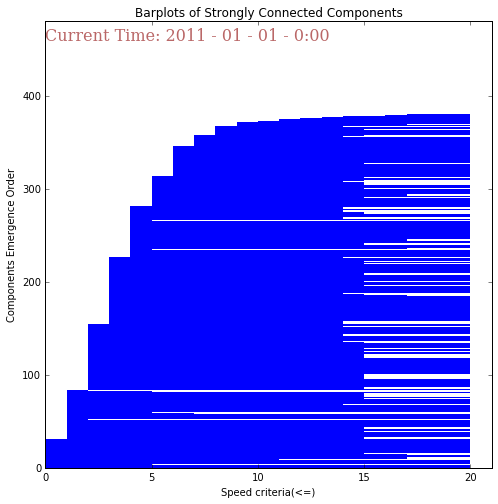

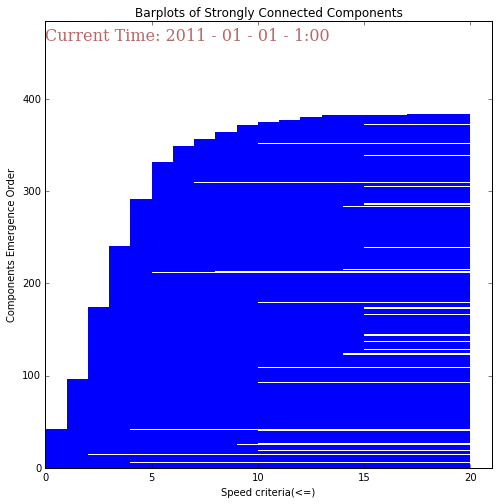

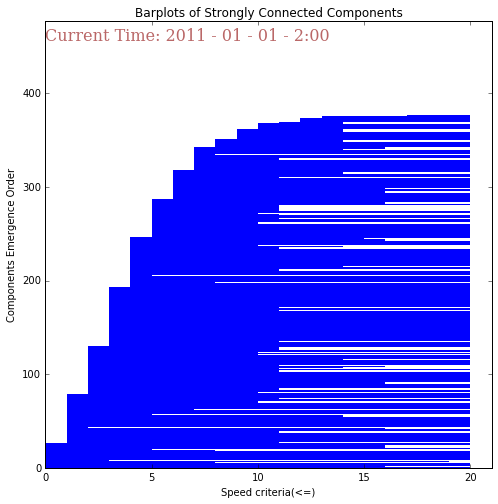

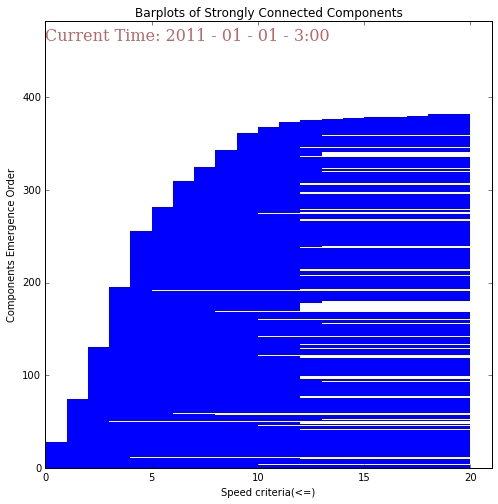

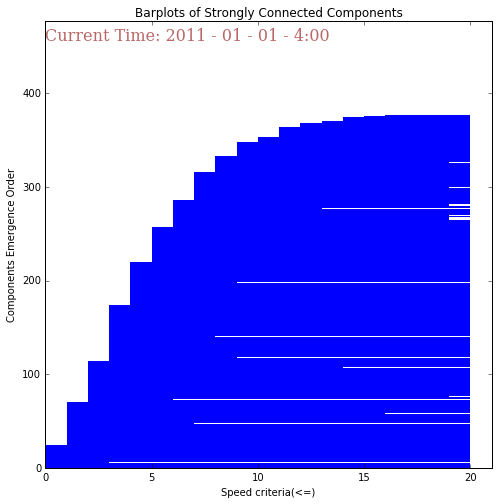

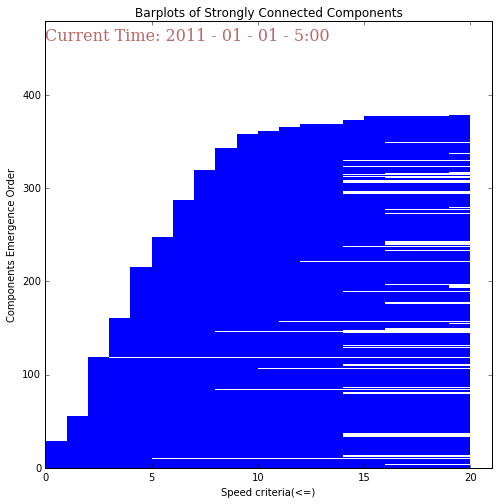

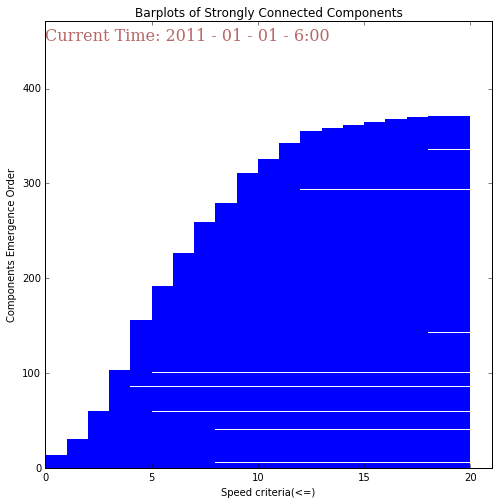

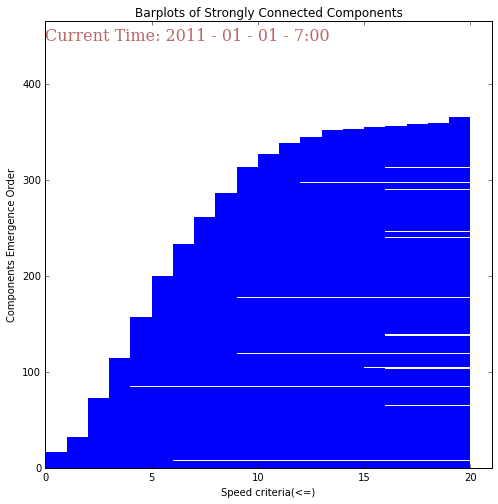

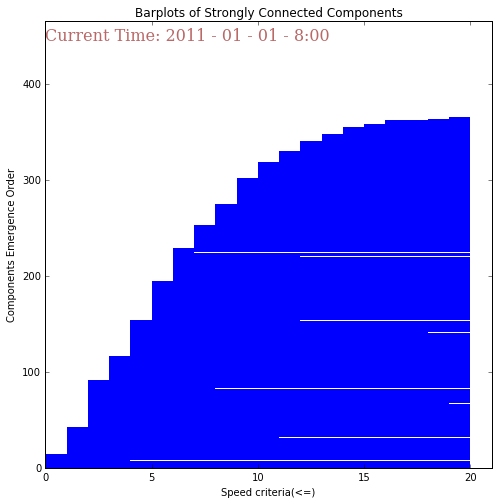

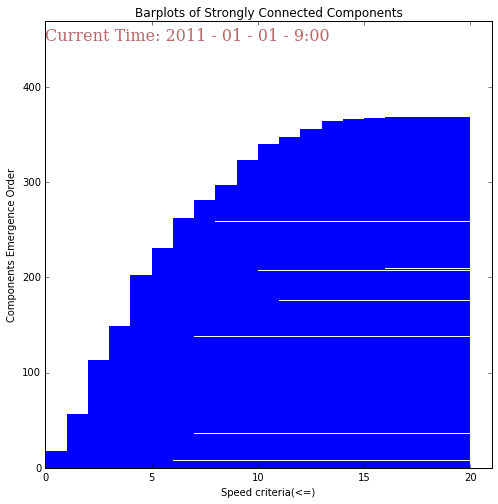

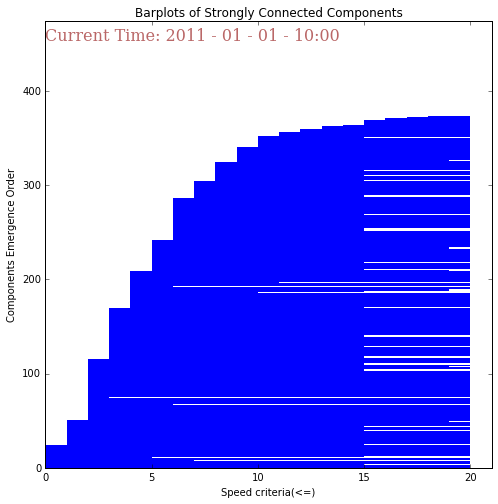

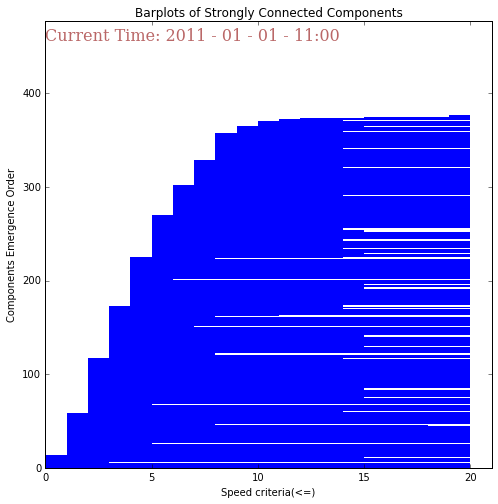

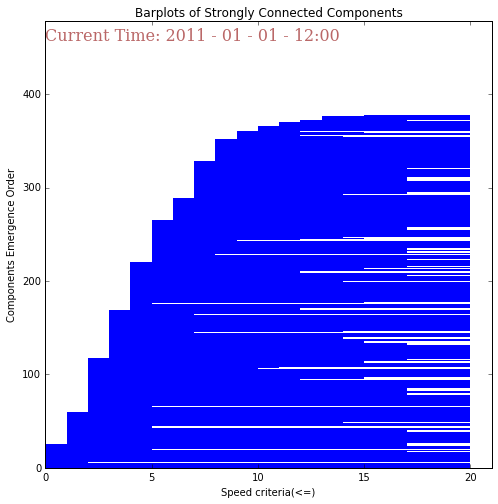

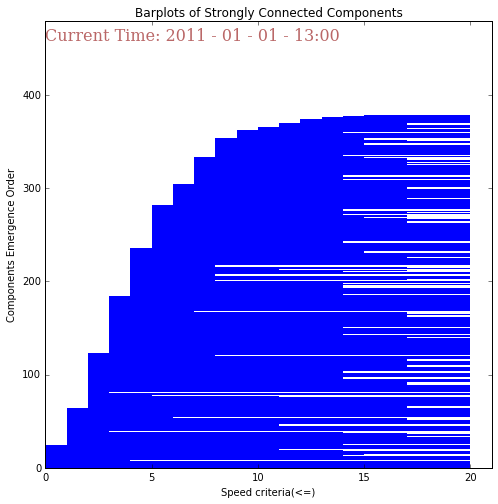

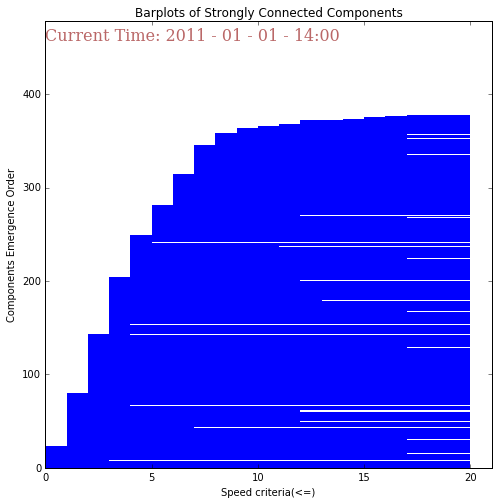

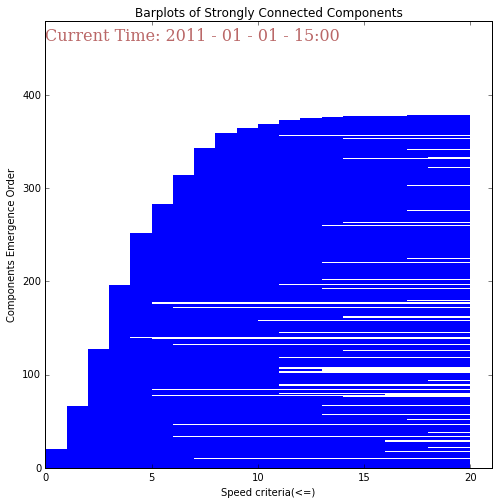

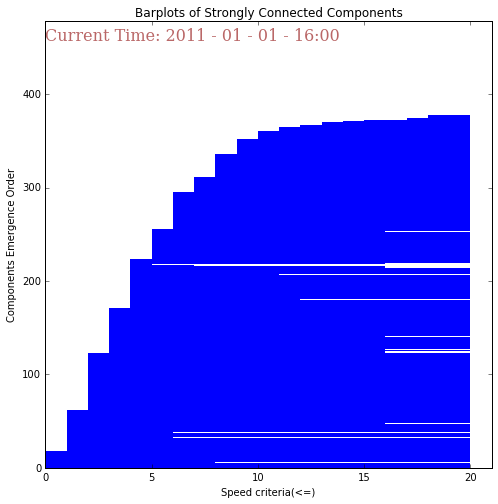

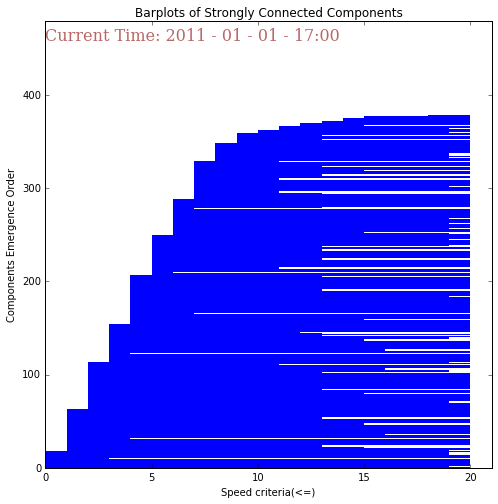

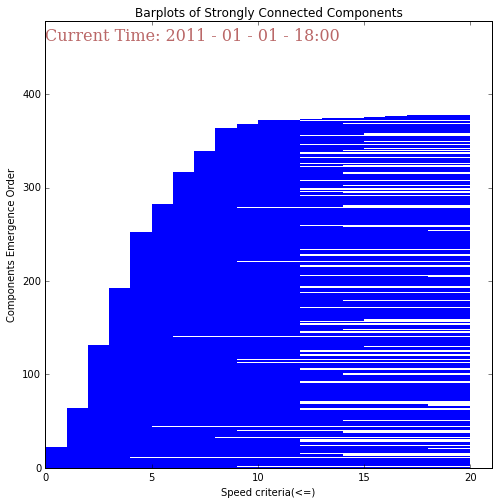

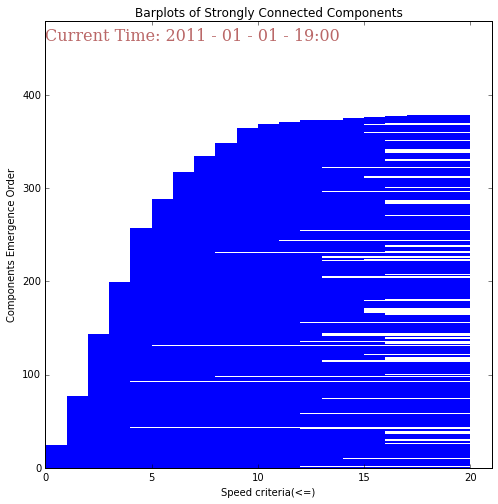

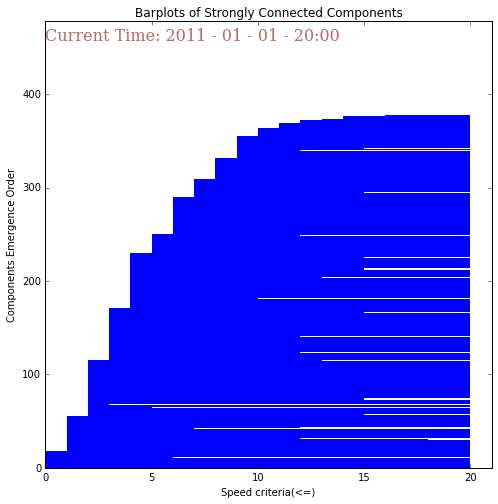

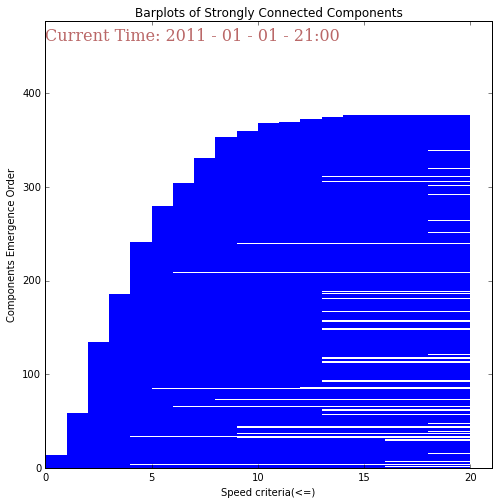

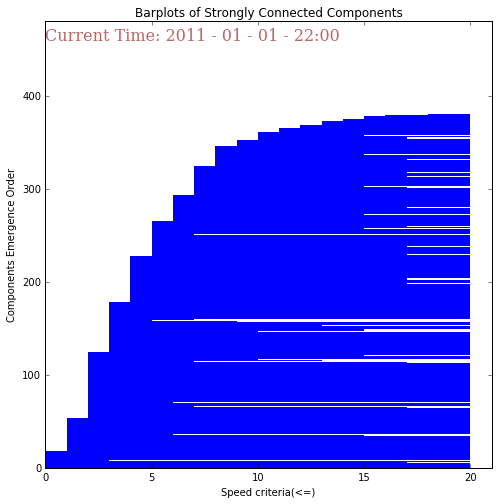

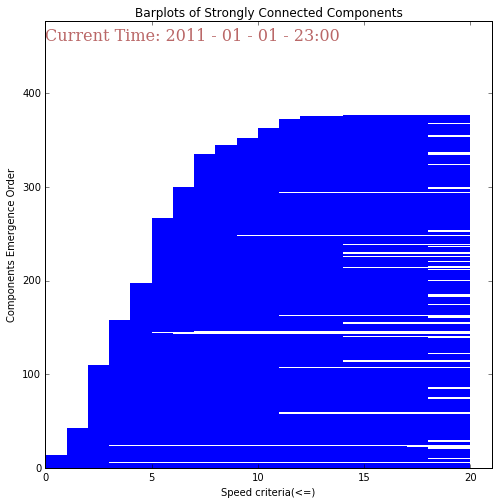

In [15]:
limit = 21
thresholds = list(np.arange(1,limit,1))
MaxorderList = []
LifeLists = []
Link_to_Order_List = []
Time_Slices = []
for i in range(len(thresholds)):
    Time_Slices.append([])
for t in range(24):
    clinkslists = []
    cCompLists = []
    cCompLists_Node = []
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        qualify_links = block_g.filterEdges(lambda e: e.getSpeedAt(0, t) < threshold)
        sub_g = block_g.subgraph(qualify_links)
        cur_scc = sub_g.scc()
        cur_scc_node = sub_g.sccNode()
        cCompLists.append(cur_scc)
        cCompLists_Node.append(cur_scc_node)
        clinkslists.append(reduce(lambda x, y: x+y, cur_scc, []))
        #print("length of scc",len(cur_scc))
        Time_Slices[i].append(len(cur_scc))
    Maxorder, Lifes, Link_to_Order = DrawBarcode(cCompLists_Node, thresholds, t, "scc")
    MaxorderList.append(Maxorder)
    LifeLists.append(Lifes)
    Link_to_Order_List.append(Link_to_Order)


<Container object of 24 artists>

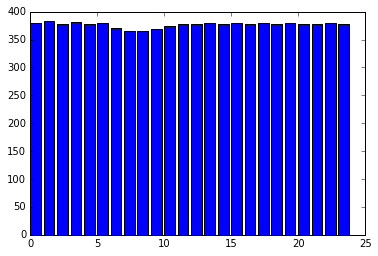

In [18]:
plt.bar(list(range(0,24)),MaxorderList)

(0, 10)

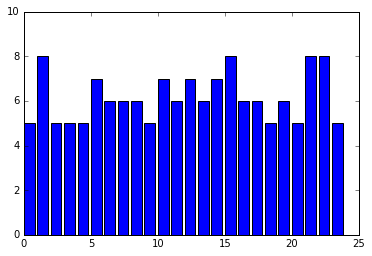

In [21]:
#under 20mile/h
plt.bar(range(0,24),Time_Slices[-1])
plt.ylim(0,10)

In [22]:
import folium
#from folium.features import (WmsTileLayer, RegularPolygonMarker, Vega, GeoJson,
#                       CircleMarker, LatLngPopup,
#                       ClickForMarker, TopoJson, PolyLine, MultiPolyLine,
#                       )
from folium.features import *
NY_COORDINATES = (40.7272,-73.98)
m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=13)
folium.Marker(
    location=[40.800864,-73.946513],
    popup='40.800864,-73.946513',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.796035,-73.935286],
    popup='40.796035,-73.935286',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.762957,-73.974149],
    popup='40.762957,-73.974149',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.758385,-73.962978],
    popup='40.758385,-73.962978',
    icon=folium.Icon(icon='cloud')
).add_to(m)
#194781
#folium.Marker(
#    location=[g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x],
#    popup='194781',
#    icon=folium.Icon(icon='cloud')
#).add_to(m)
#m
#g.drawEdges(m,tttemp,colors,1)
g.drawEdges(m,qualify_area,colors,1)
m

In [23]:
print(g.nodes[g.edges[206413].start].y,
g.nodes[g.edges[206413].start].x,
g.nodes[g.edges[206413].end].y,
g.nodes[g.edges[206413].end].x)

40.7772273 -73.9461727 40.7766012 -73.9466301


In [24]:
temp1 = np.cross(np.array([g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x])-upperLeft,upperRight - upperLeft)
temp2 = np.cross(np.array([g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x])-upperRight,lowerRight - upperRight)
temp3 = np.cross(np.array([g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x])-lowerRight,lowerLeft - lowerRight)
temp4 = np.cross(np.array([g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x])-lowerLeft, upperLeft - lowerLeft)

## NYC Marathon and Concert

In [25]:
#(40.800864,-73.946513); (40.796035,-73.935286); (40.762957,-73.974149); (40.758385,-73.962978)
upperLeft = np.array([40.800864,-73.946513])
upperRight = np.array([40.796035,-73.935286])
lowerLeft = np.array([40.762957,-73.974149])
lowerRight = np.array([(40.758385,-73.962978)])

In [26]:
#qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, 3) < 11)
qualify_area = g.getSubArea(upperLeft, upperRight, lowerLeft, lowerRight)
#g.drawEdges(m,qualify_area,colors,1)
idLists = [e.idx for e in qualify_area]
sub_g_e = good_links[good_links['link_id'].isin(idLists)]
#links[links['link_id'].isin(full_links)]
block_g = Graph()
for i,l in sub_g_e.iterrows():
    block_g.add_edge(l)
idxToId = list(sub_g_e['link_id'])
for i, idx in enumerate(idxToId):
    block_g.edges[idx].setTime(d[:,i])

In [27]:
import folium
#from folium.features import (WmsTileLayer, RegularPolygonMarker, Vega, GeoJson,
#                       CircleMarker, LatLngPopup,
#                       ClickForMarker, TopoJson, PolyLine, MultiPolyLine,
#                       )
from folium.features import *
NY_COORDINATES = (40.7272,-73.98)
m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=13)
folium.Marker(
    location=[40.800864,-73.946513],
    popup='40.800864,-73.946513',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.796035,-73.935286],
    popup='40.796035,-73.935286',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.762957,-73.974149],
    popup='40.762957,-73.974149',
    icon=folium.Icon(icon='cloud')
).add_to(m)
folium.Marker(
    location=[40.758385,-73.962978],
    popup='40.758385,-73.962978',
    icon=folium.Icon(icon='cloud')
).add_to(m)
#194781
#folium.Marker(
#    location=[g.nodes[g.edges[194781].start].y,g.nodes[g.edges[194781].start].x],
#    popup='194781',
#    icon=folium.Icon(icon='cloud')
#).add_to(m)
#m
#g.drawEdges(m,tttemp,colors,1)
g.drawEdges(m,qualify_area,colors,1)
m

qualified links =  5
qualified links =  23
qualified links =  41
qualified links =  64
qualified links =  84
qualified links =  105
qualified links =  141
qualified links =  157
qualified links =  186
qualified links =  214
qualified links =  234
qualified links =  253
qualified links =  270
qualified links =  276
qualified links =  285
qualified links =  289
qualified links =  293
qualified links =  298
qualified links =  300
qualified links =  304
qualified links =  306
qualified links =  308
qualified links =  311
qualified links =  313
qualified links =  316
qualified links =  317
qualified links =  320
qualified links =  323

/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



qualified links =  323
qualified links =  323
qualified links =  326
qualified links =  327
qualified links =  327
qualified links =  327
Max order340
qualified links =  7
qualified links =  31
qualified links =  47
qualified links =  64
qualified links =  91
qualified links =  119
qualified links =  141
qualified links =  158
qualified links =  181
qualified links =  200
qualified links =  214
qualified links =  232
qualified links =  248
qualified links =  258
qualified links =  266


/Users/ziying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


qualified links =  270
qualified links =  274
qualified links =  280
qualified links =  284
qualified links =  286
qualified links =  288
qualified links =  291
qualified links =  294
qualified links =  296
qualified links =  298
qualified links =  301
qualified links =  302
qualified links =  306
qualified links =  306
qualified links =  307
qualified links =  307
qualified links =  307
qualified links =  307
qualified links =  308
Max order337
qualified links =  8
qualified links =  19
qualified links =  44
qualified links =  63
qualified links =  90
qualified links =  111
qualified links =  127
qualified links =  142
qualified links =  178
qualified links =  200
qualified links =  211
qualified links =  217
qualified links =  230
qualified links =  240
qualified links =  243
qualified links =  247
qualified links =  251
qualified links =  254
qualified links =  258
qualified links =  259
qualified links =  260
qualified links =  261
qualified links =  264
qualified links =  264
qual

qualified links =  16
qualified links =  53
qualified links =  91
qualified links =  124
qualified links =  154
qualified links =  197
qualified links =  210
qualified links =  233
qualified links =  258
qualified links =  269
qualified links =  285
qualified links =  291
qualified links =  301
qualified links =  305
qualified links =  313
qualified links =  315
qualified links =  317
qualified links =  318
qualified links =  319
qualified links =  325
qualified links =  328
qualified links =  329
qualified links =  330
qualified links =  331
qualified links =  331
qualified links =  331
qualified links =  331
qualified links =  331
qualified links =  331
qualified links =  332
qualified links =  333
qualified links =  334
qualified links =  334
qualified links =  334
Max order340
qualified links =  19
qualified links =  48
qualified links =  101
qualified links =  134
qualified links =  168
qualified links =  206
qualified links =  230
qualified links =  249
qualified links =  270
qua

/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


qualified links =  6
qualified links =  24
qualified links =  46
qualified links =  70
qualified links =  108
qualified links =  147
qualified links =  174
qualified links =  200
qualified links =  222
qualified links =  246
qualified links =  272
qualified links =  283
qualified links =  290
qualified links =  299
qualified links =  309
qualified links =  311
qualified links =  314
qualified links =  316
qualified links =  320
qualified links =  322
qualified links =  323
qualified links =  326
qualified links =  328
qualified links =  329
qualified links =  329
qualified links =  330
qualified links =  332
qualified links =  332
qualified links =  334
qualified links =  334
qualified links =  334
qualified links =  334
qualified links =  334
qualified links =  334
Max order340
qualified links =  5
qualified links =  28
qualified links =  50
qualified links =  90
qualified links =  139
qualified links =  168
qualified links =  186
qualified links =  202
qualified links =  241
qualifie

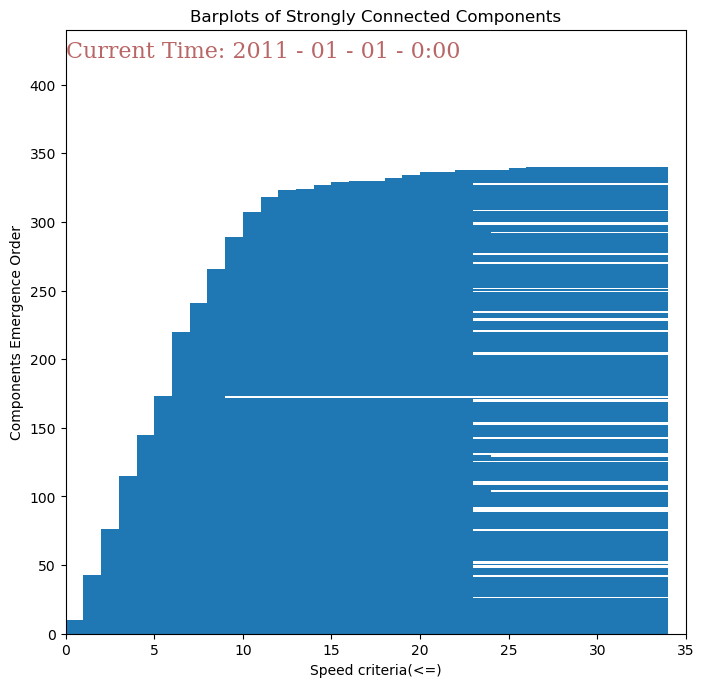

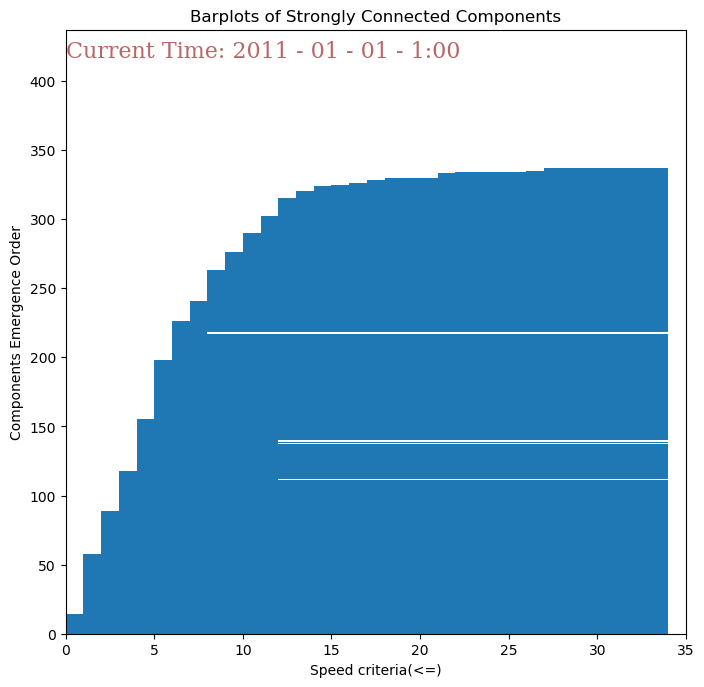

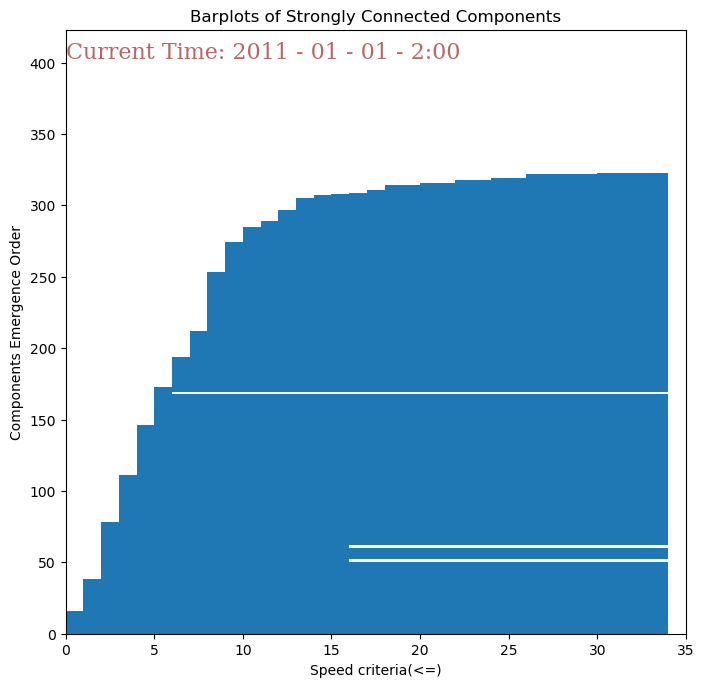

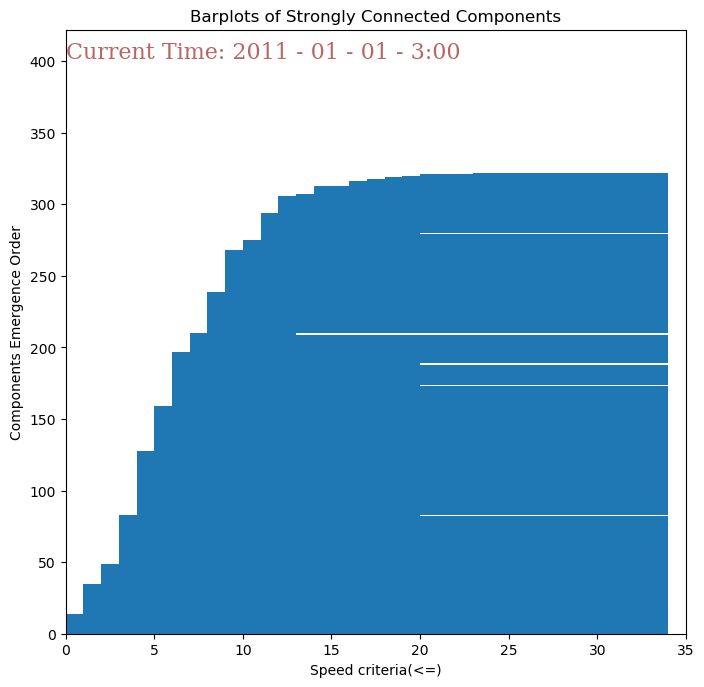

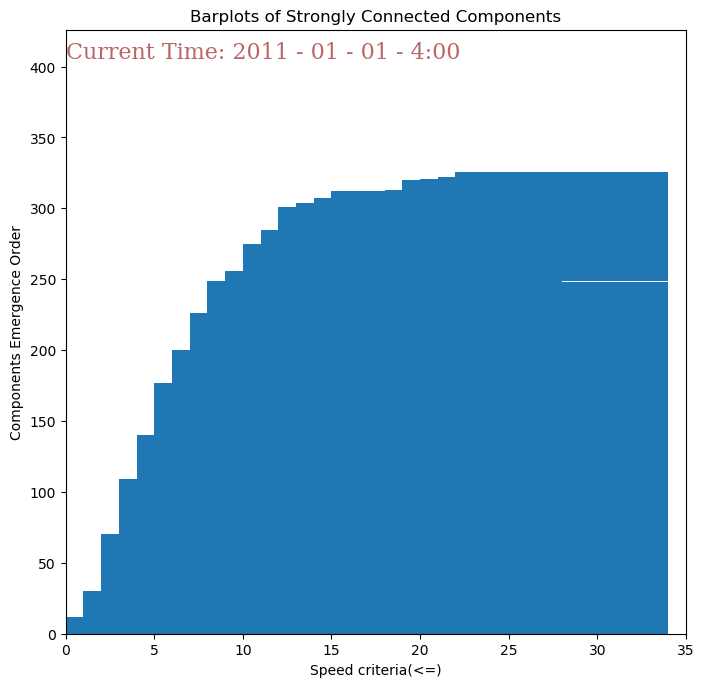

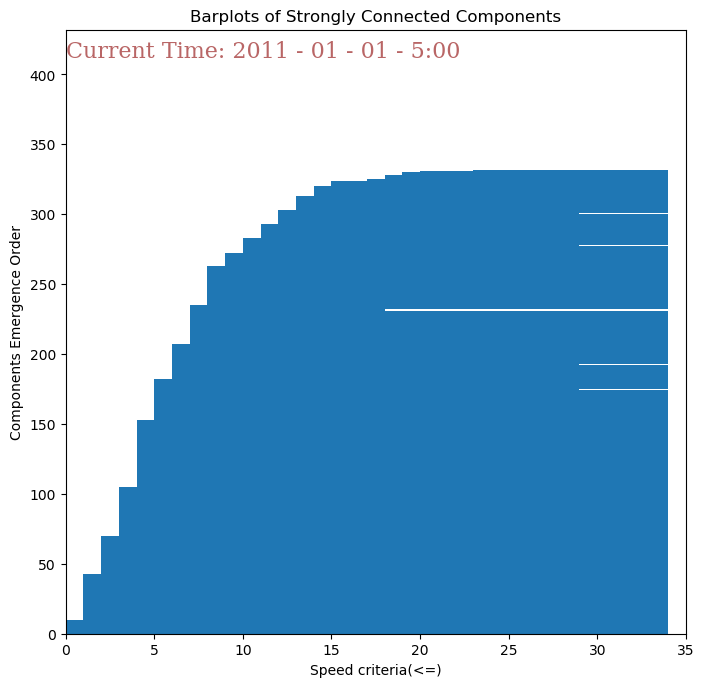

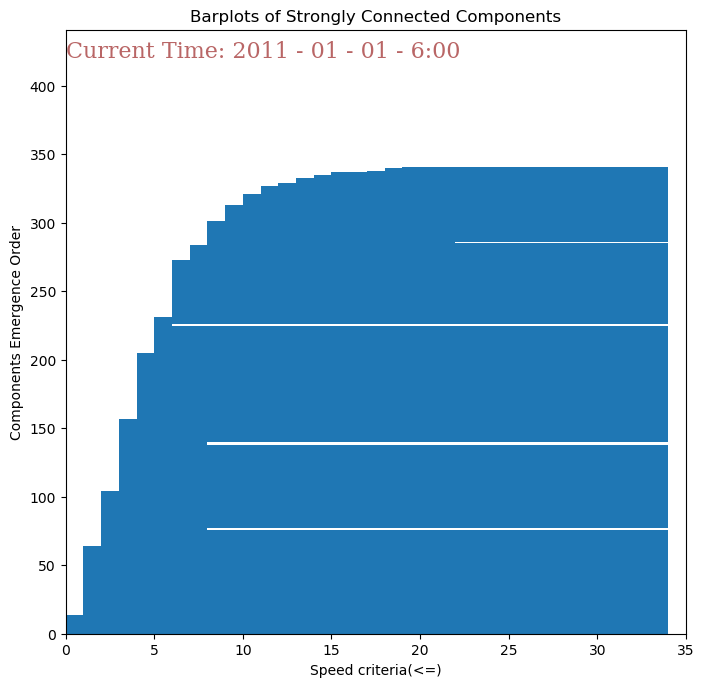

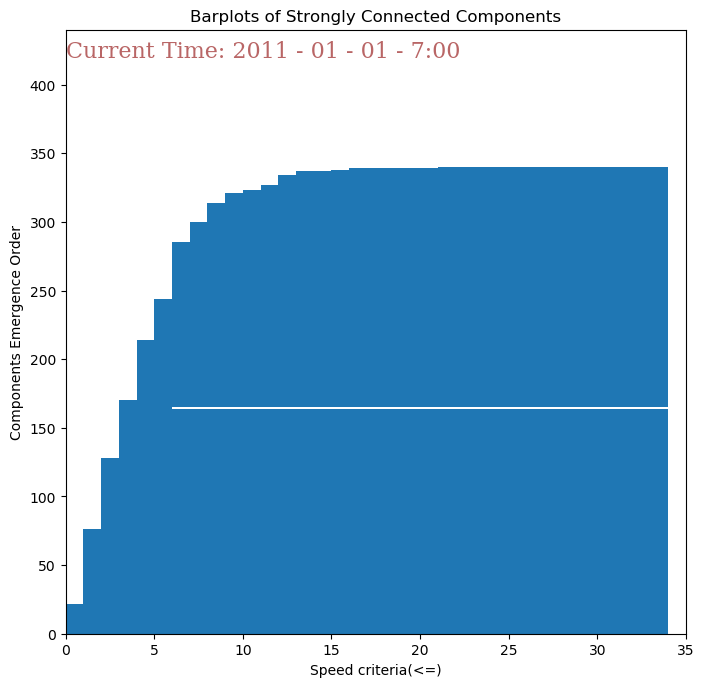

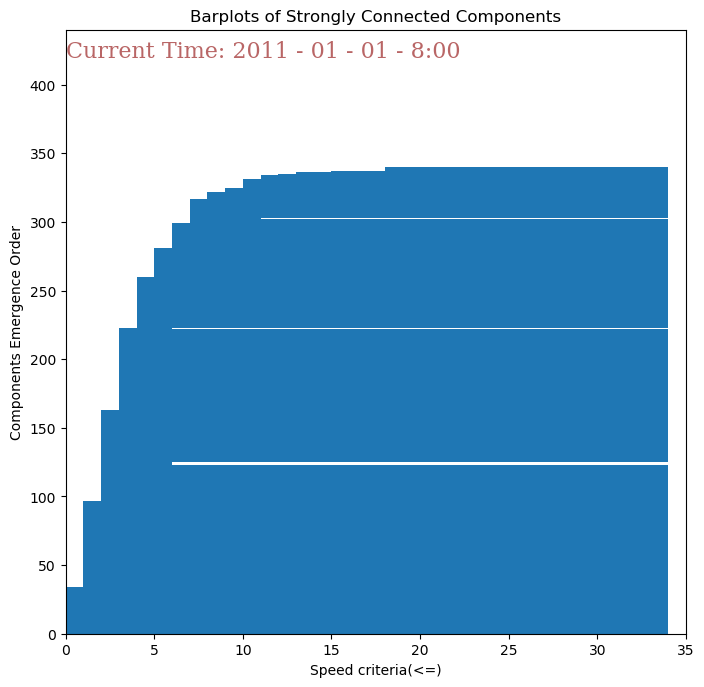

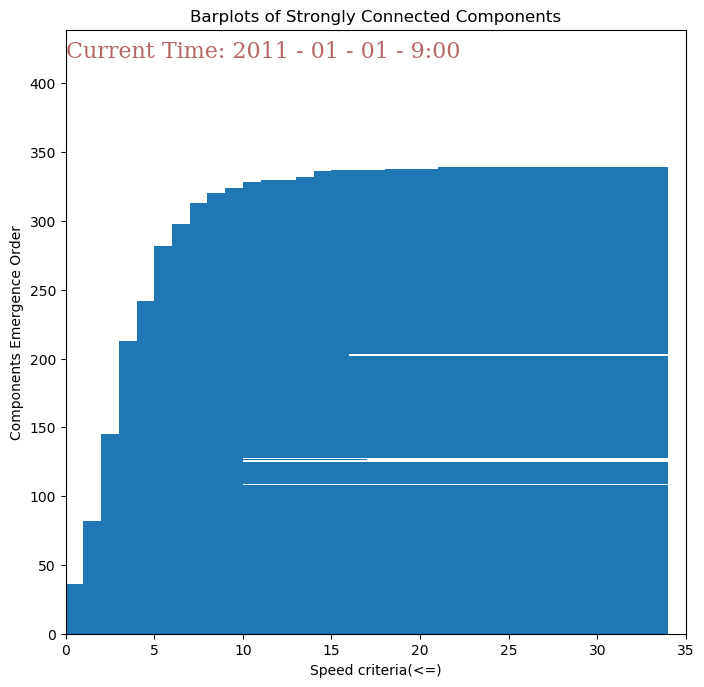

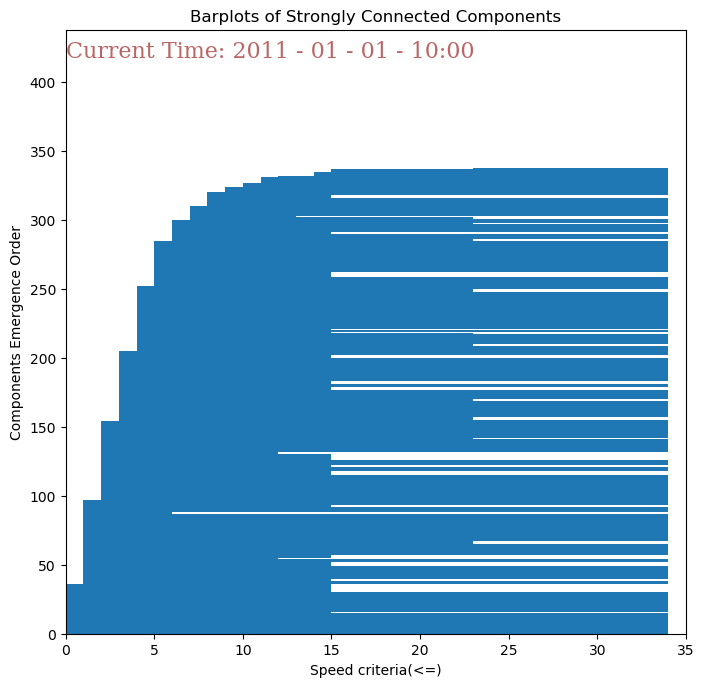

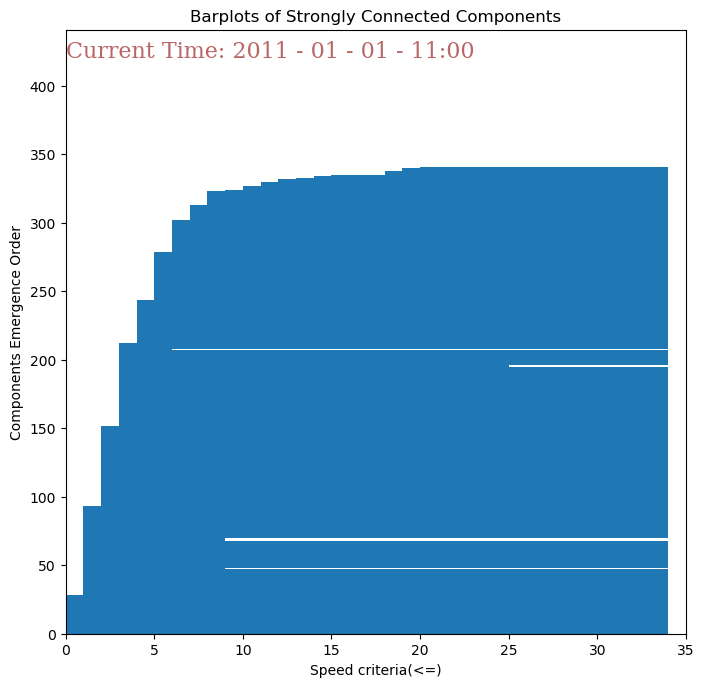

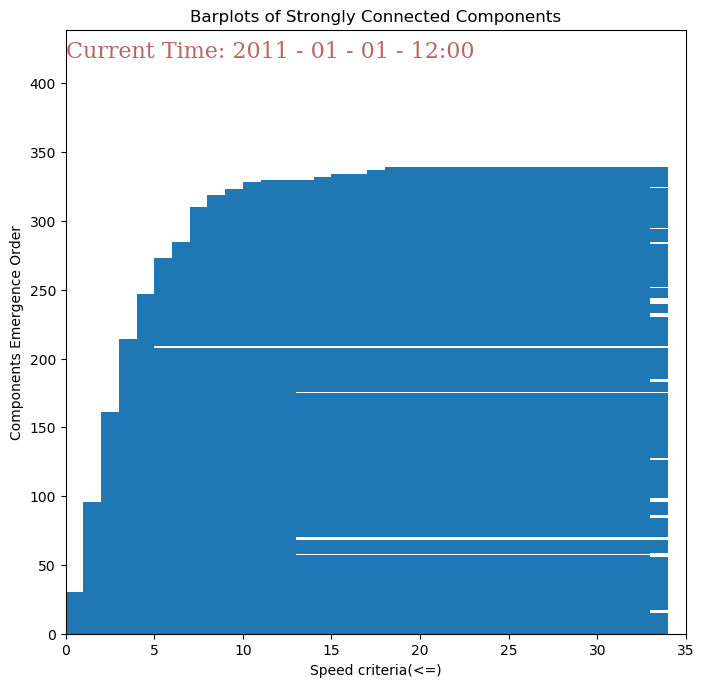

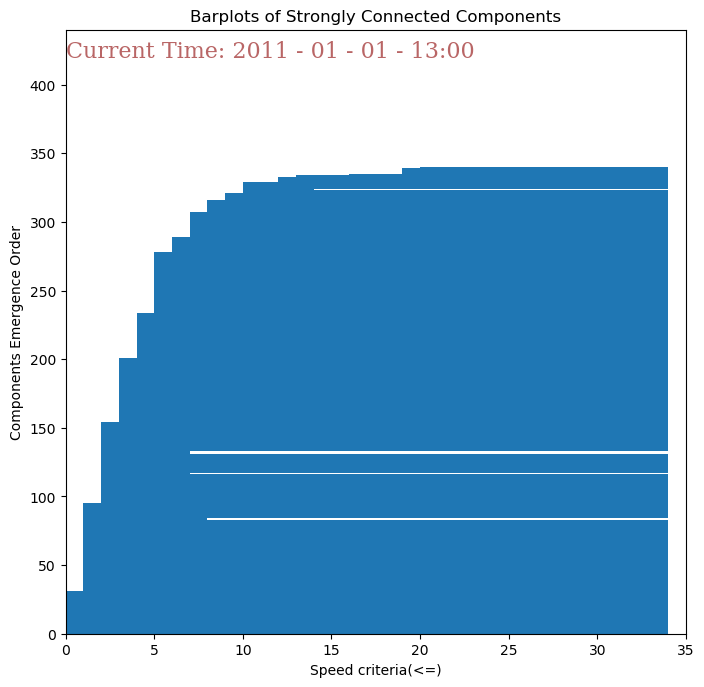

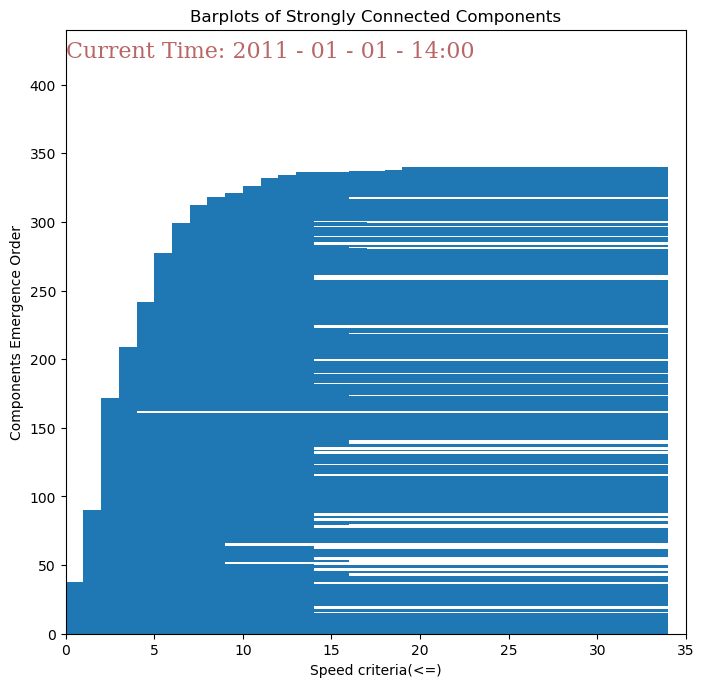

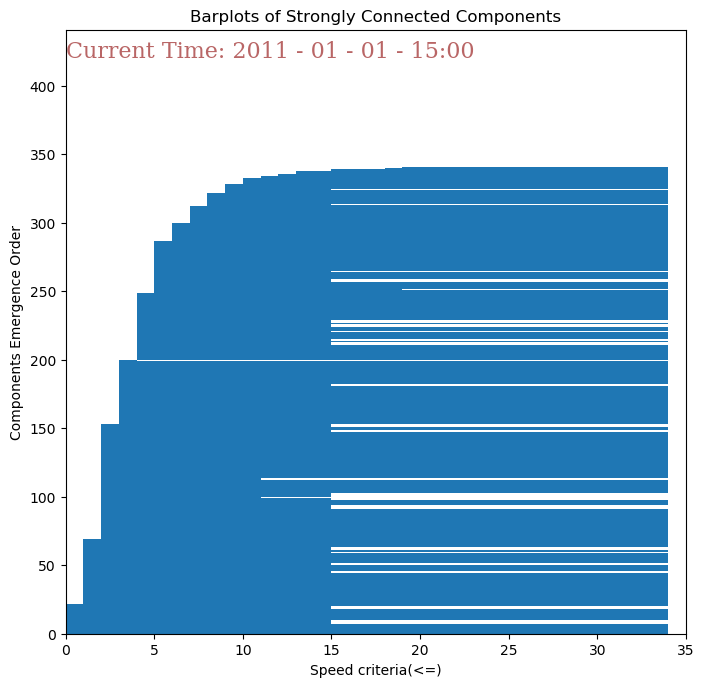

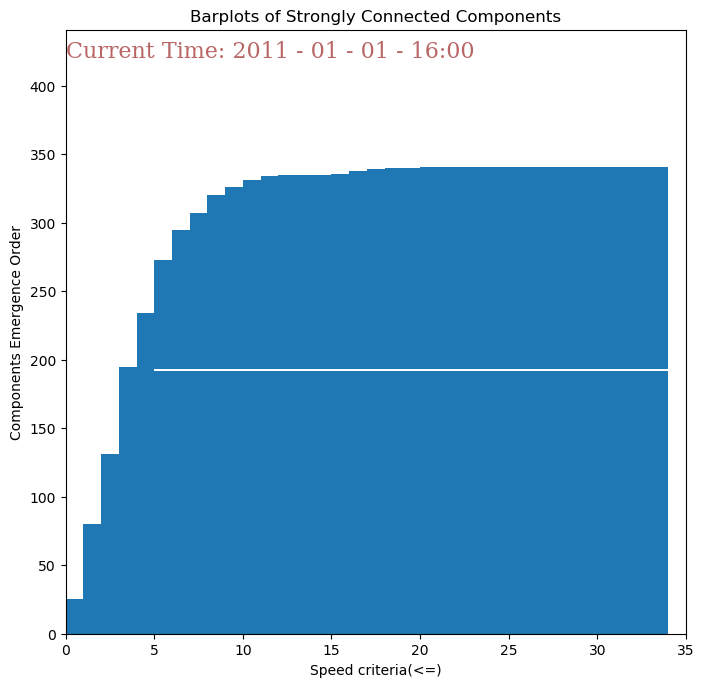

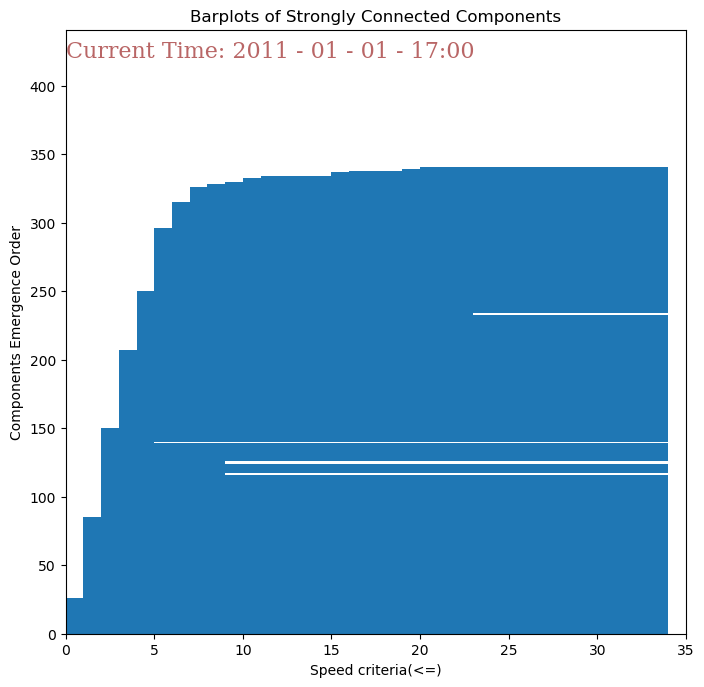

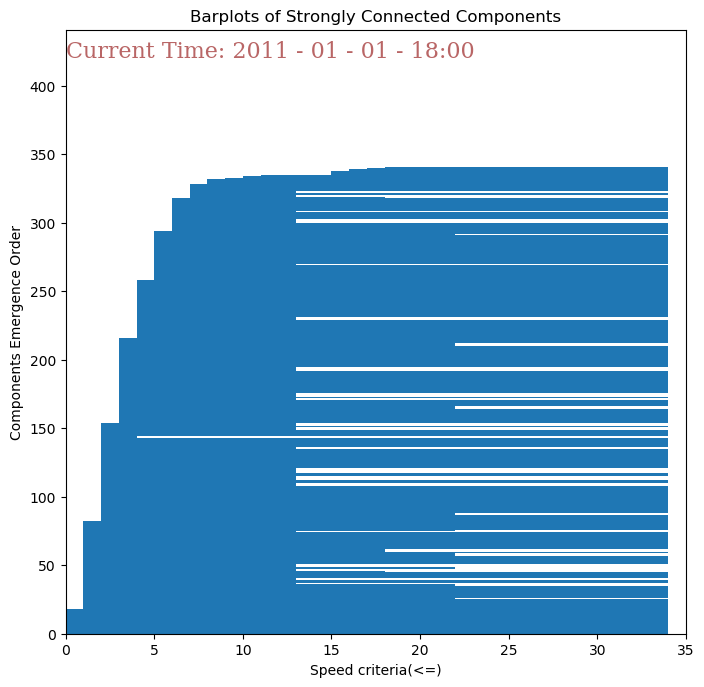

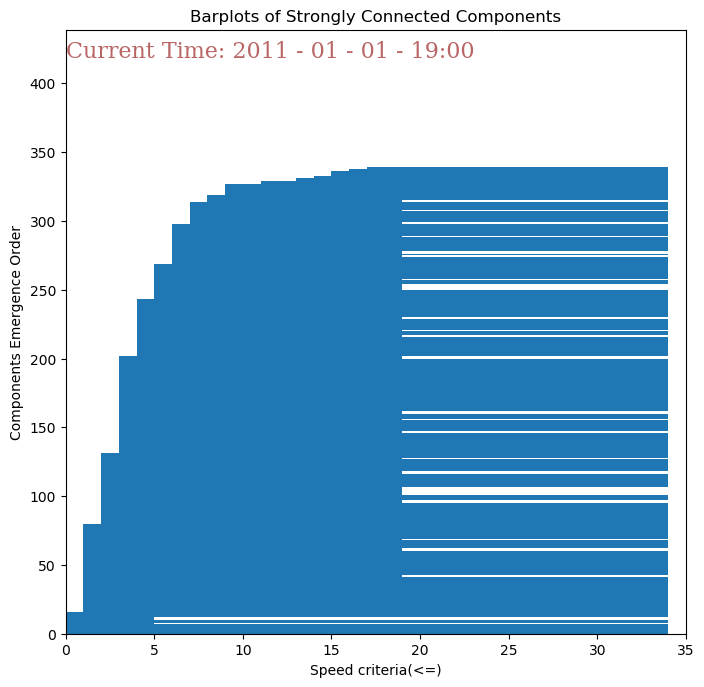

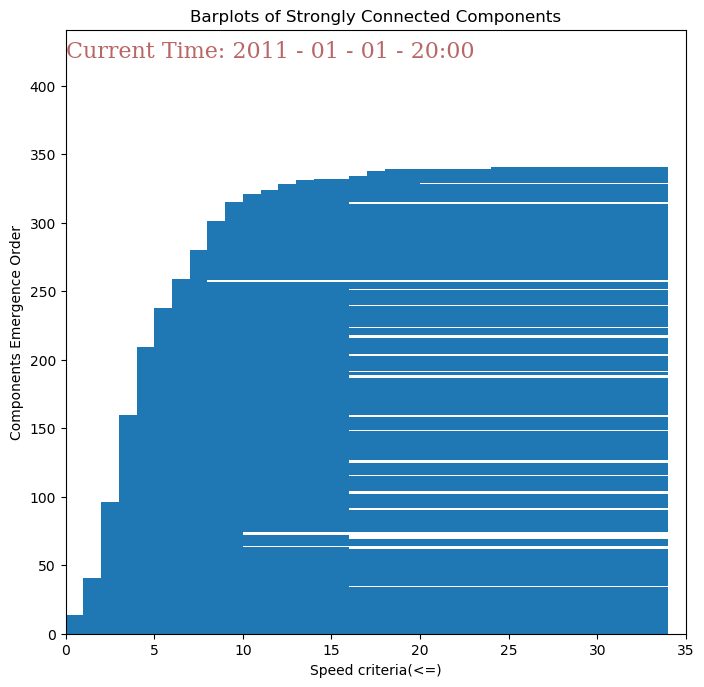

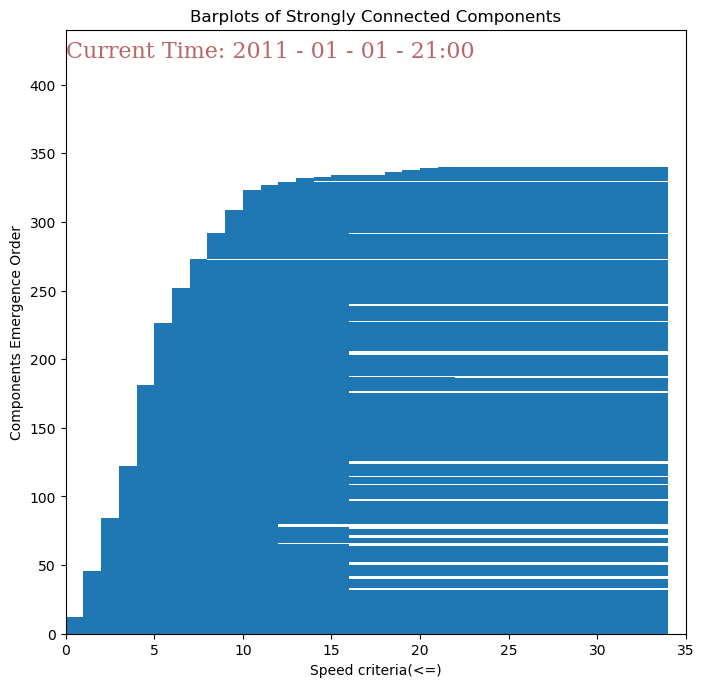

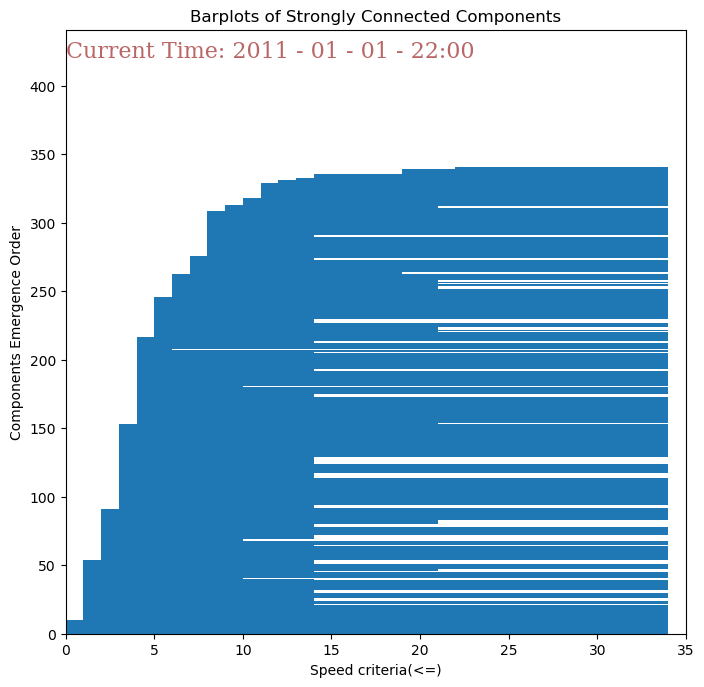

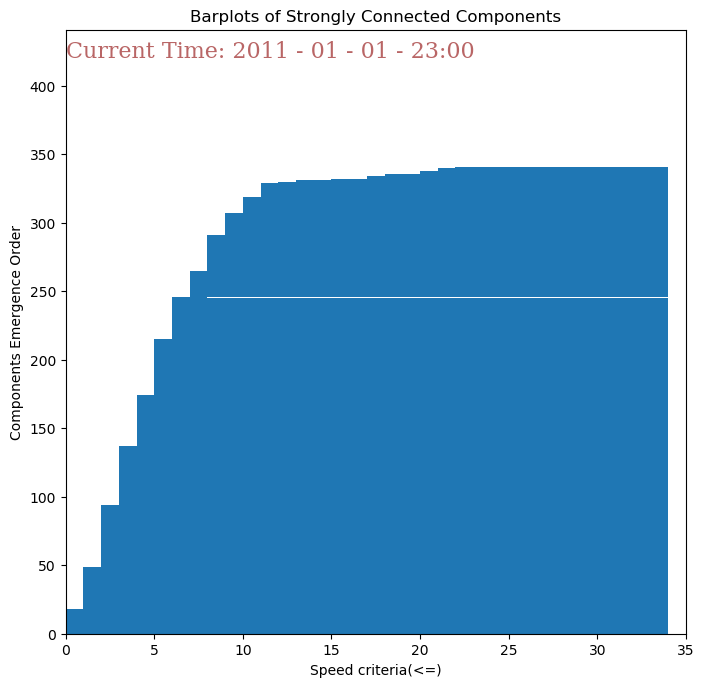

In [49]:
#11.6 
numday = 31+28+31+30+31+30+31+31+30+31+6
limit = 35
thresholds = list(np.arange(1,limit,1))
MaxorderList = []
LifeLists = []
Link_to_Order_List = []
Time_Slices = []
for i in range(len(thresholds)):
    Time_Slices.append([])
for t in range(24):
    clinkslists = []
    cCompLists = []
    cCompLists_Node = []
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        qualify_links = block_g.filterEdges(lambda e: e.getSpeedAt(numday, t) < threshold)
        print("qualified links = ", len(qualify_links))
        sub_g = block_g.subgraph(qualify_links)
        cur_scc = sub_g.scc()
        cur_scc_node = sub_g.sccNode()
        cCompLists.append(cur_scc)
        cCompLists_Node.append(cur_scc_node)
        clinkslists.append(reduce(lambda x, y: x+y, cur_scc, []))
        #print("length of scc",len(cur_scc))
        Time_Slices[i].append(len(cur_scc))
    if t == 1:
        for j in range(len(cCompLists)):
            m1 =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=13)
            #print("in", i, "comp")
            for k in range(len(cCompLists[j])):
                g.drawEdges(m1,cCompLists[j][k],colors,k%len(colors))
            m1.save('./area_maps/scc_tmp_{}.html'.format(str(i)))
    Maxorder, Lifes, Link_to_Order = DrawBarcode(cCompLists_Node, thresholds, t, "scc")
    MaxorderList.append(Maxorder)
    LifeLists.append(Lifes)
    Link_to_Order_List.append(Link_to_Order)



In [59]:
    # def scc(self):
     #   scs = tarjan({k:[e.end for e in self.out[k]] for k in self.out})
      #  return self._getEdgesFromScc(scs)

threshold = thresholds[0]
qualify_links = block_g.filterEdges(lambda e: e.getSpeedAt(numday, 0) < threshold)
print("qualified links = ", len(qualify_links))
sub_g = block_g.subgraph(qualify_links)
m2 =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=13)
sub_g.drawEdges(m2,qualify_links,colors,1)
cur_scc = sub_g.scc()
m2

qualified links =  5


In [68]:
sub_g.scc()

[]

In [69]:
sub_g.sccNode()

[[42436510],
 [42456683],
 [42437425],
 [42445976],
 [42443050],
 [42443052],
 [42456711],
 [42432395],
 [42439563],
 [42430068]]

Max order339


/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Max order341
Max order340
Max order337
Max order333
Max order329
Max order337
Max order339
Max order340
Max order337
Max order338
Max order338
Max order339
Max order337
Max order338
Max order336
Max order336
Max order338
Max order341
Max order341
Max order340


/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Max order340
Max order341
Max order337


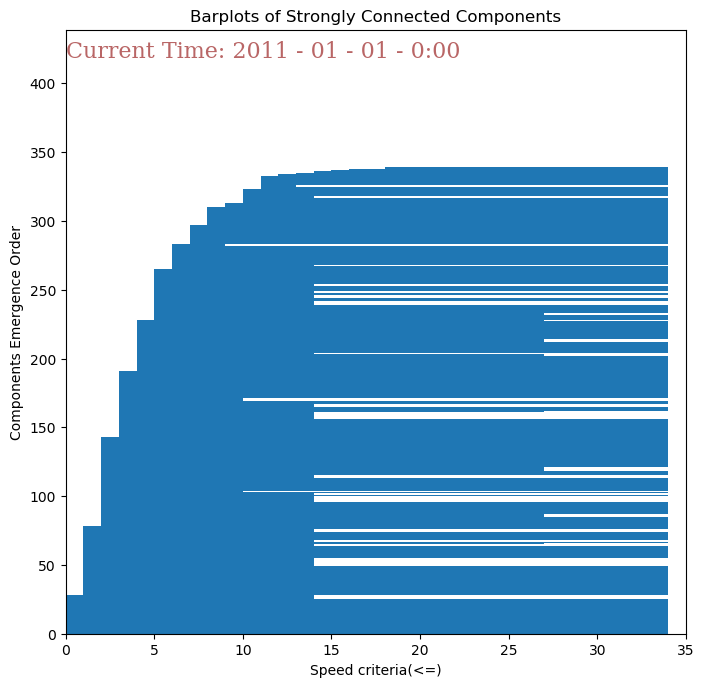

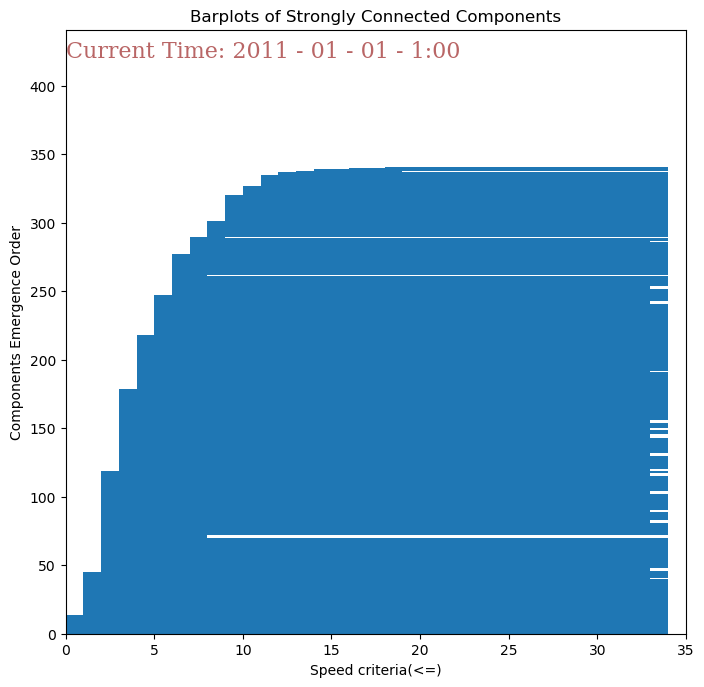

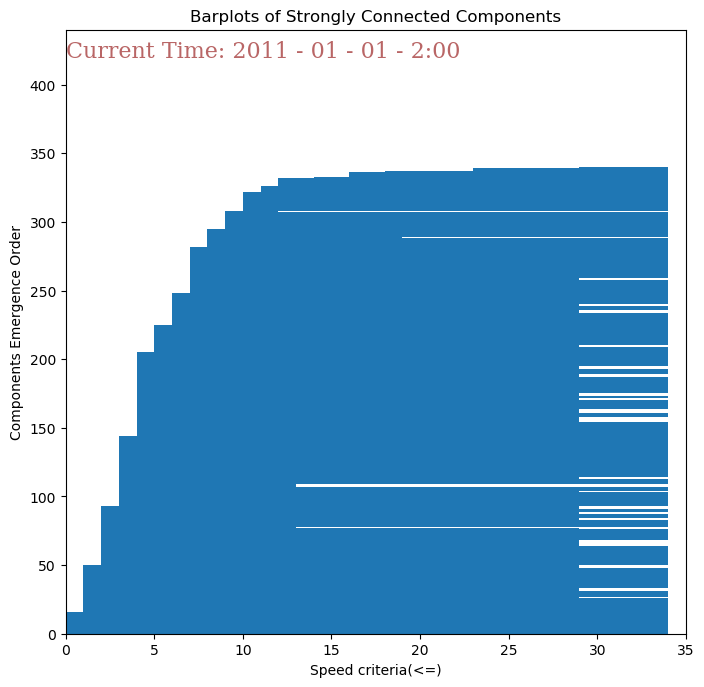

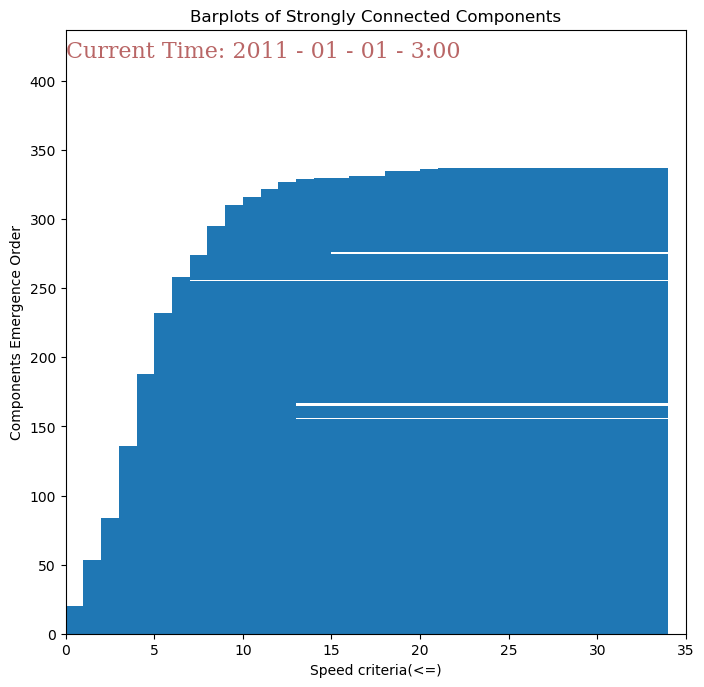

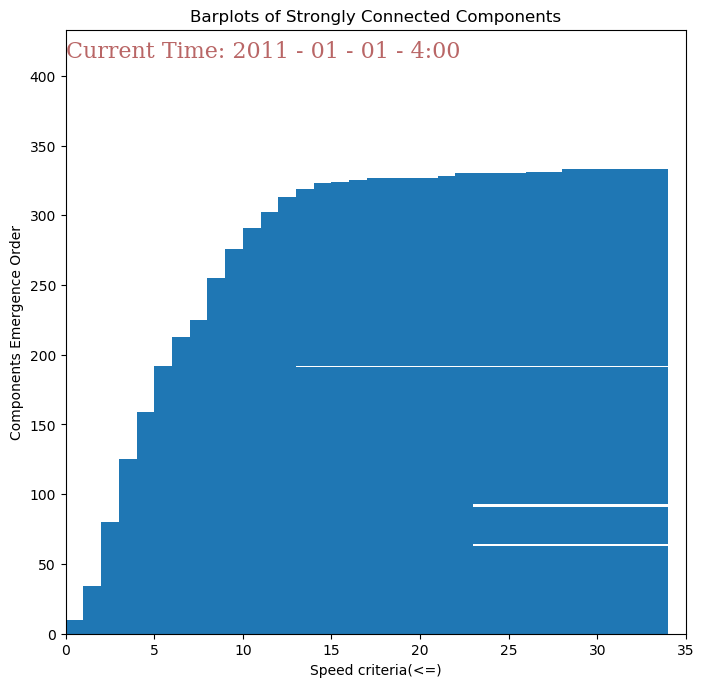

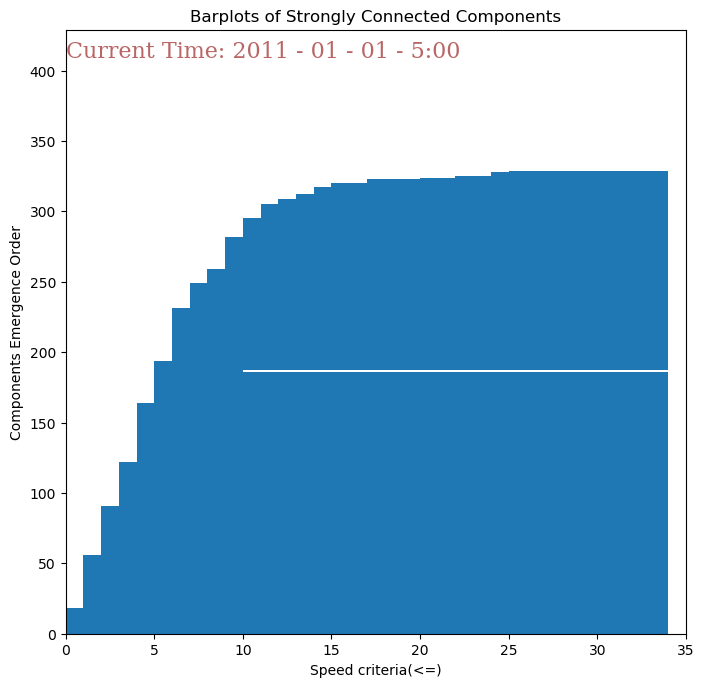

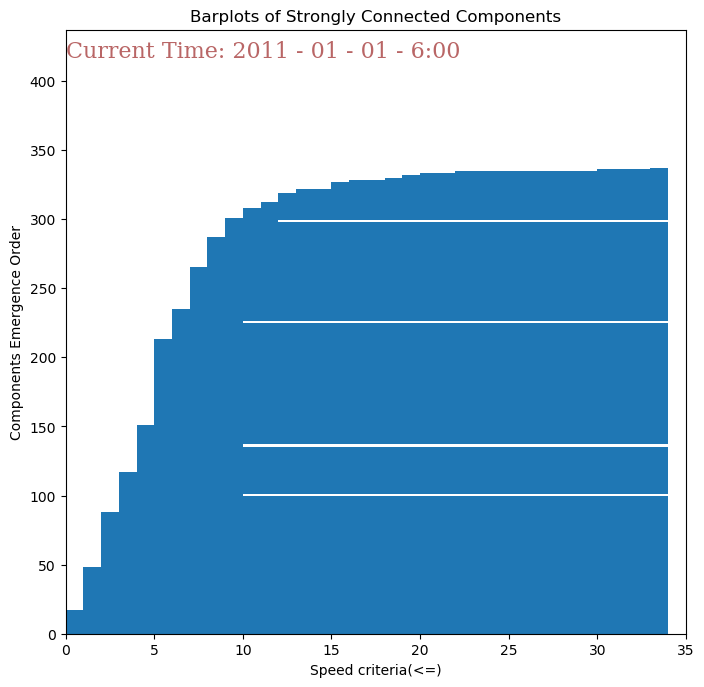

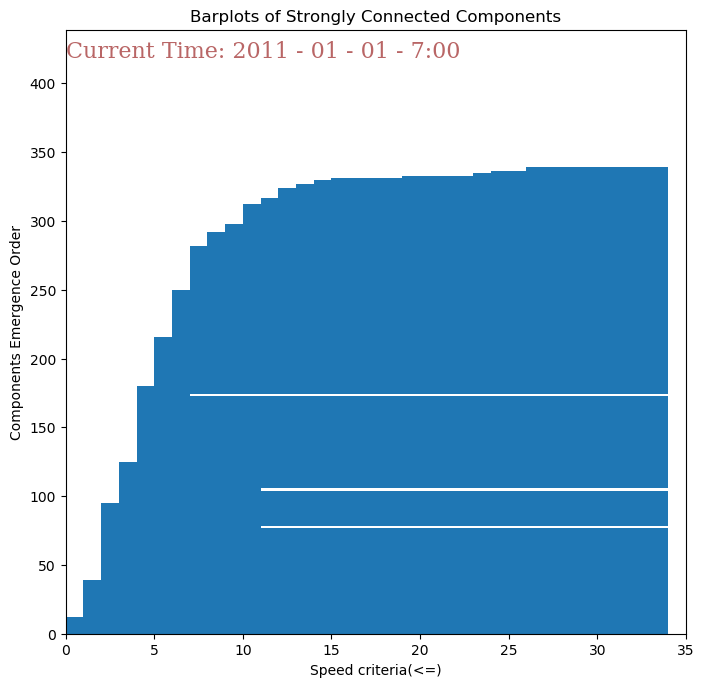

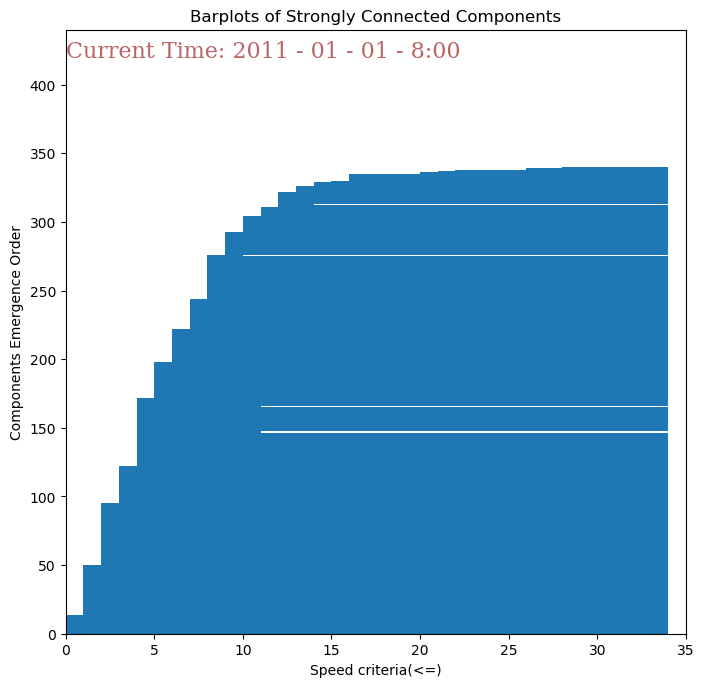

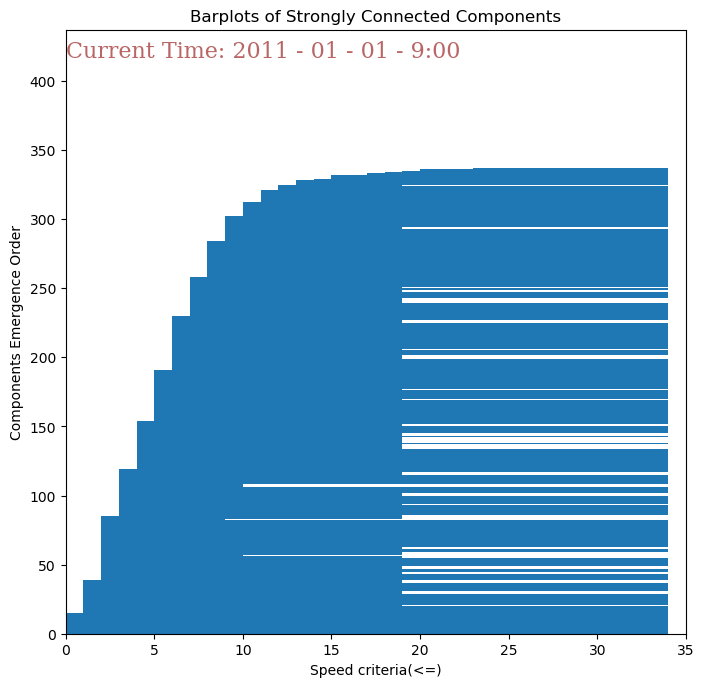

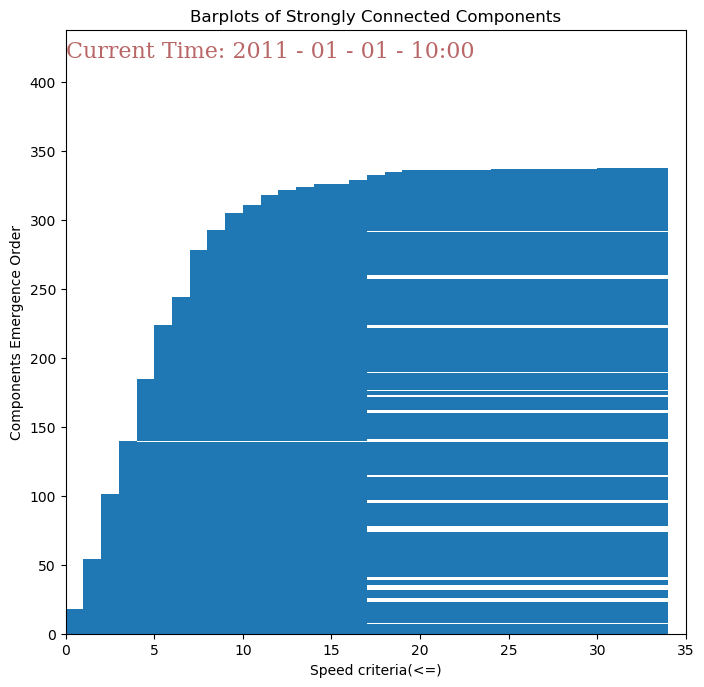

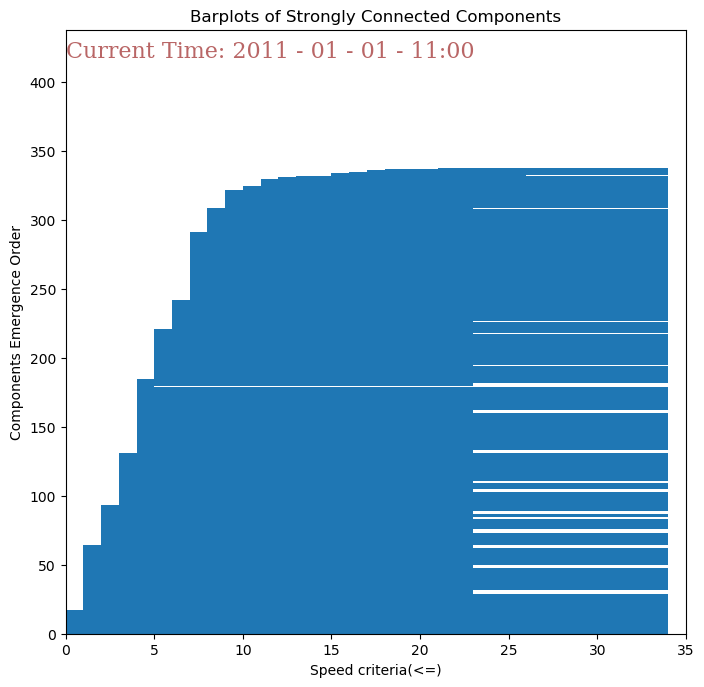

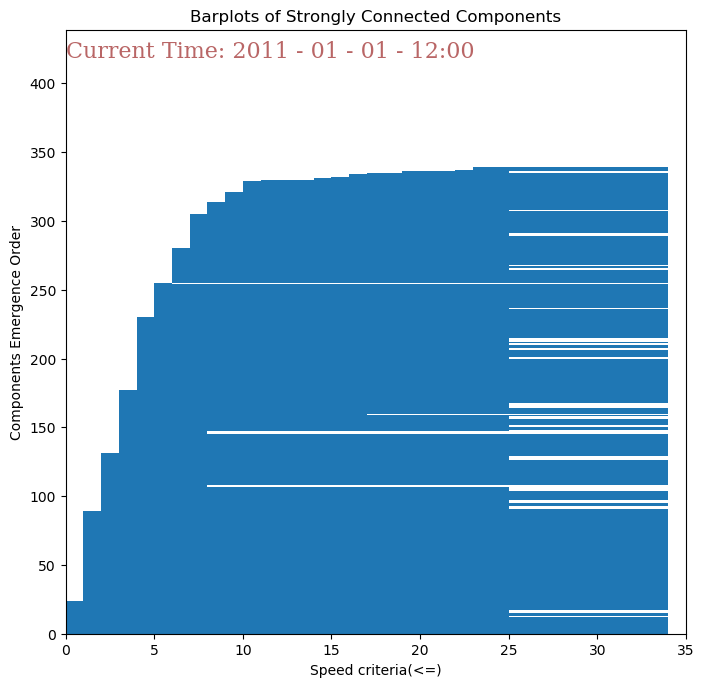

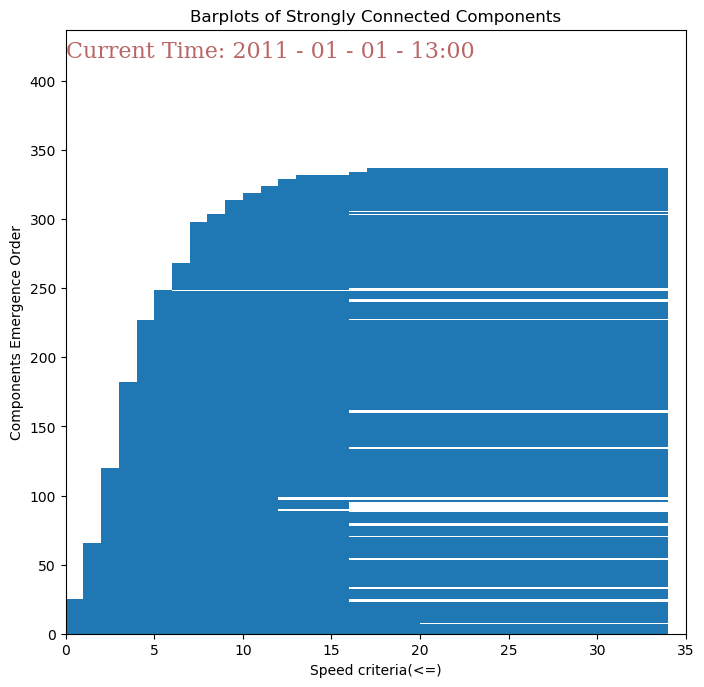

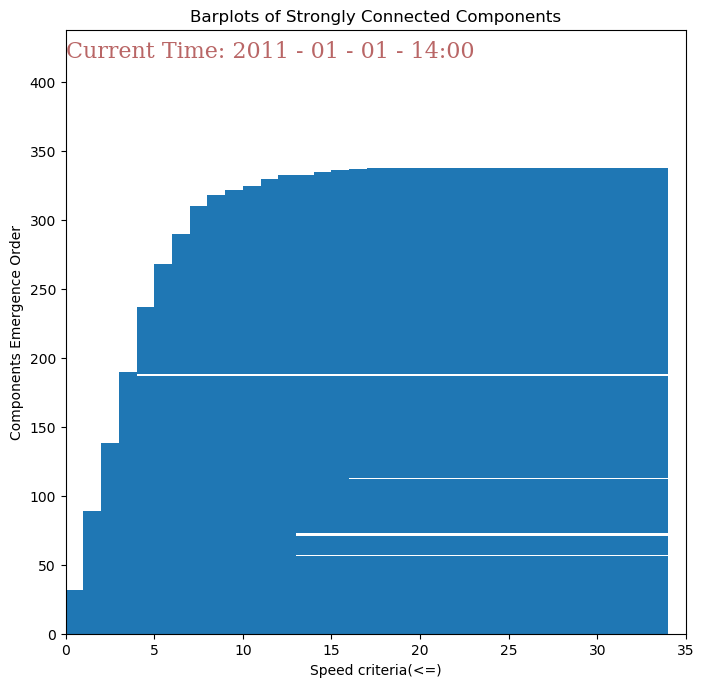

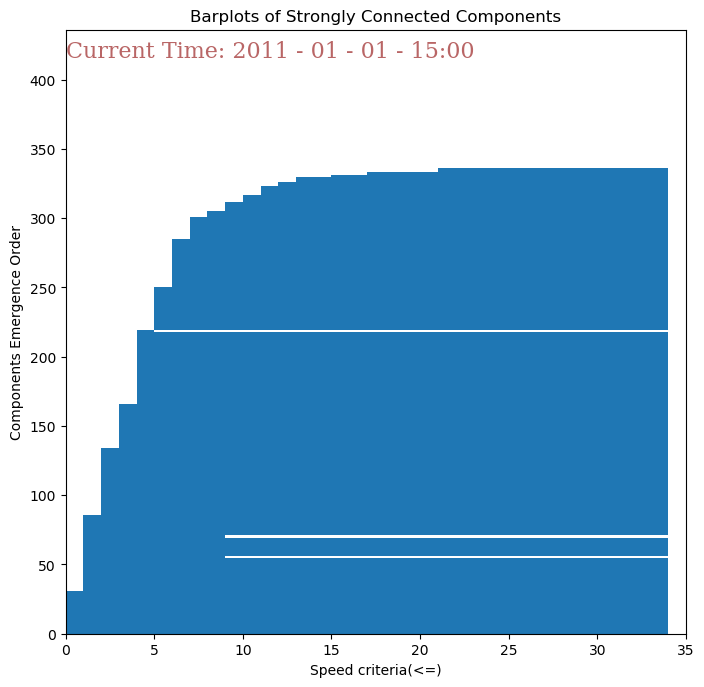

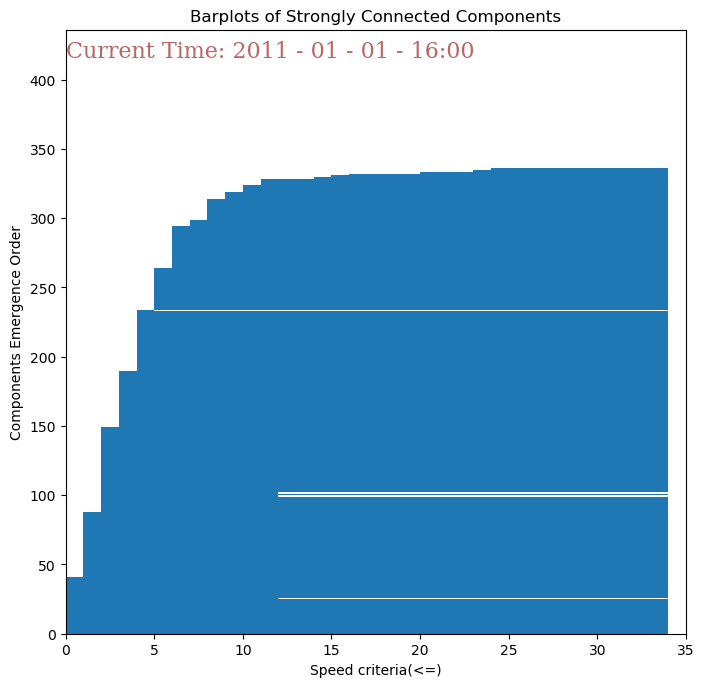

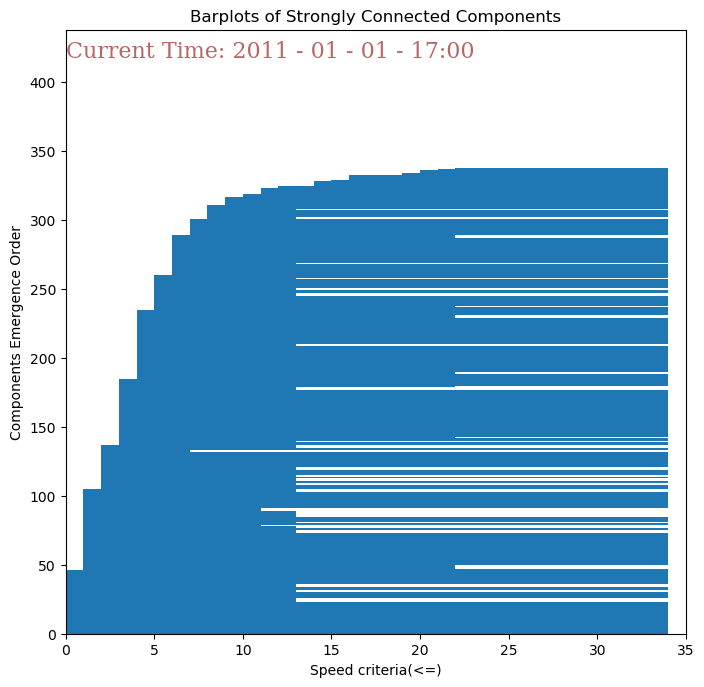

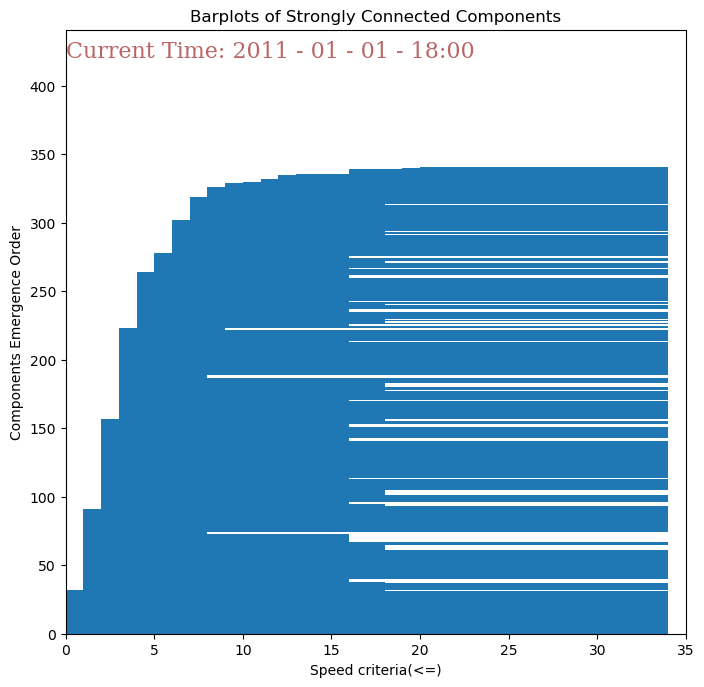

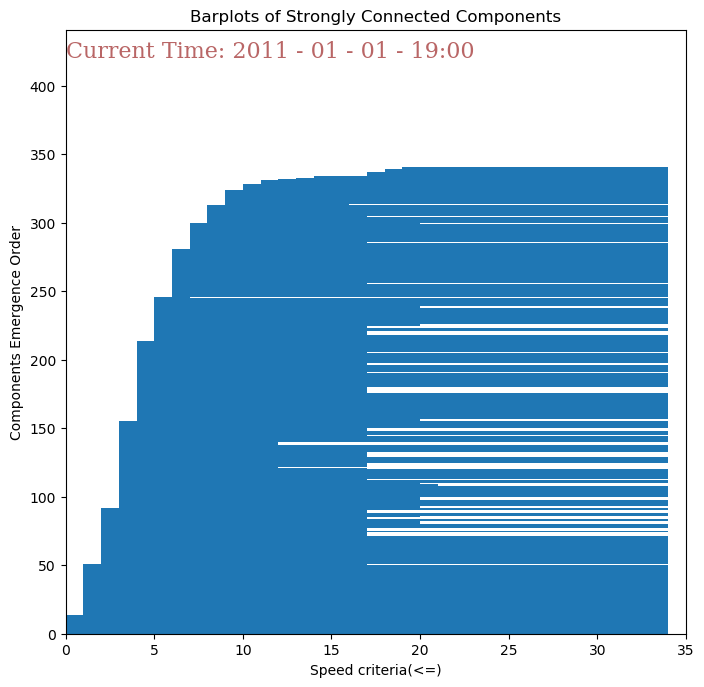

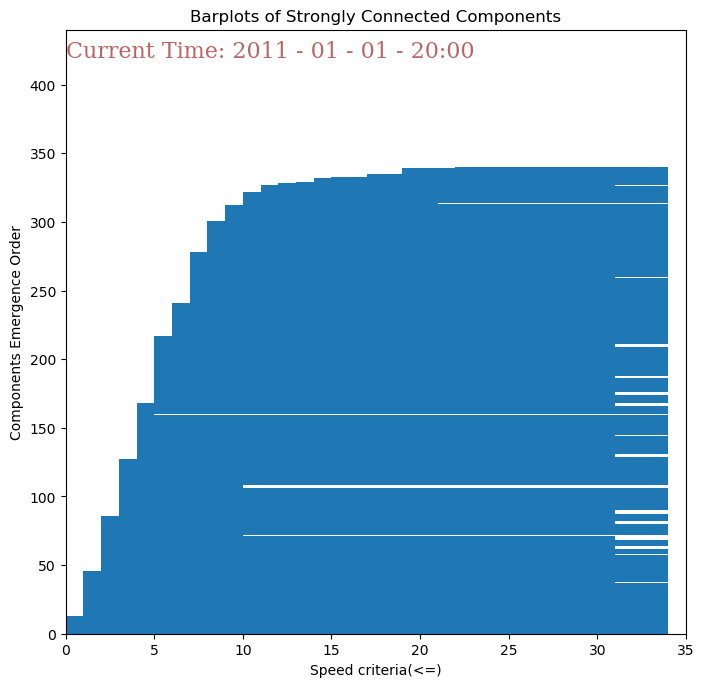

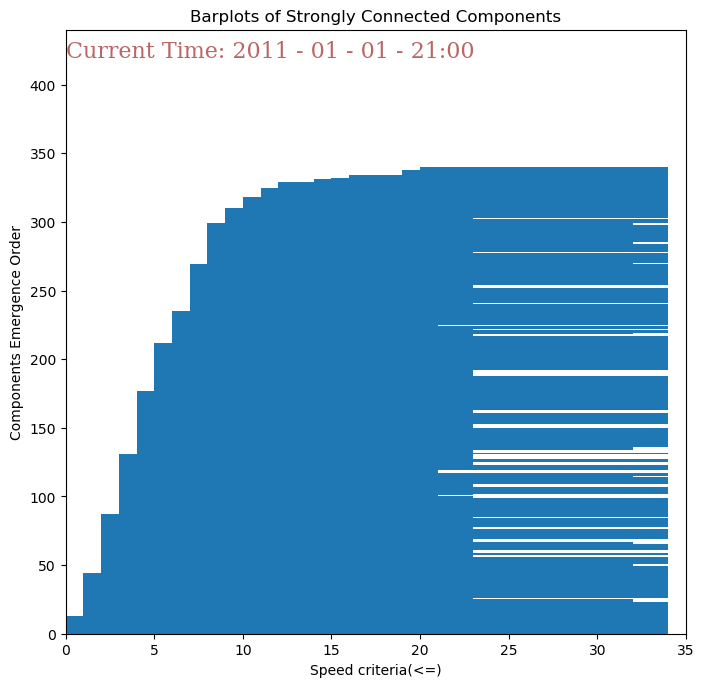

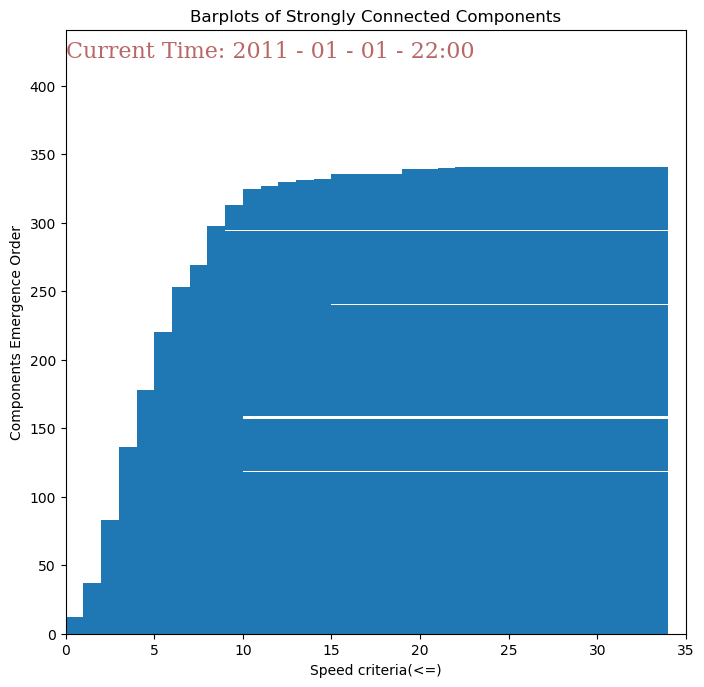

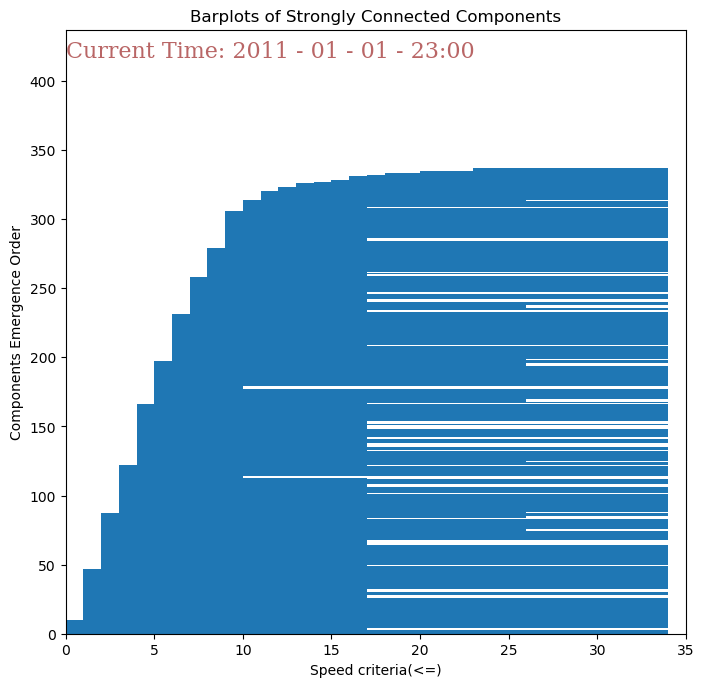

In [41]:
for t in range(24):
    clinkslists = []
    cCompLists = []
    cCompLists_Node = []
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        qualify_links = block_g.filterEdges(lambda e: e.getSpeedAt((numday-1), t) < threshold)
        sub_g = block_g.subgraph(qualify_links)
        cur_scc = sub_g.scc()
        cur_scc_node = sub_g.sccNode()
        cCompLists.append(cur_scc)
        cCompLists_Node.append(cur_scc_node)
        clinkslists.append(reduce(lambda x, y: x+y, cur_scc, []))
        #print("length of scc",len(cur_scc))
        Time_Slices[i].append(len(cur_scc))
    Maxorder, Lifes, Link_to_Order = DrawBarcode(cCompLists_Node, thresholds, t, "scc")
    MaxorderList.append(Maxorder)
    LifeLists.append(Lifes)
    Link_to_Order_List.append(Link_to_Order)

Max order340


/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Max order331
Max order326
Max order330
Max order317
Max order328
Max order339
Max order340
Max order334
Max order341
Max order341
Max order339
Max order341
Max order340
Max order341
Max order341
Max order340
Max order341
Max order341
Max order341
Max order341


/Users/ziying/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Max order341
Max order341
Max order340


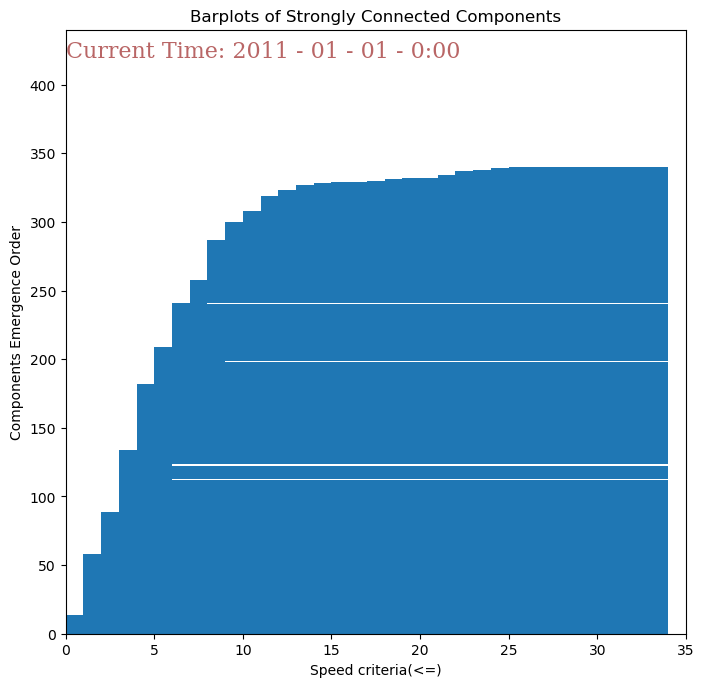

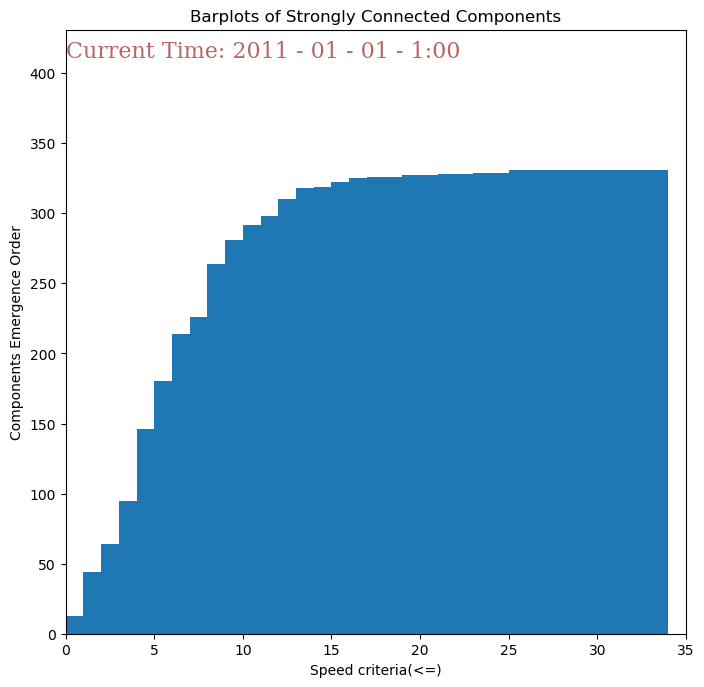

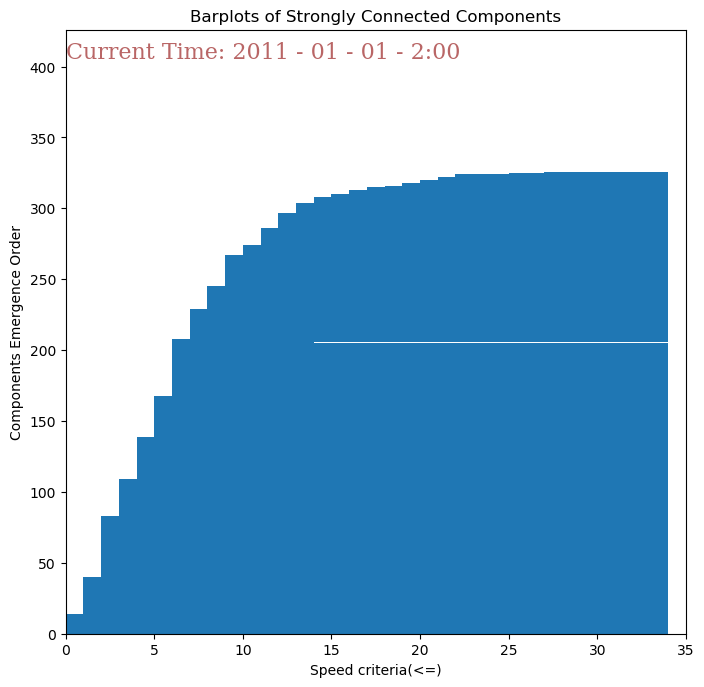

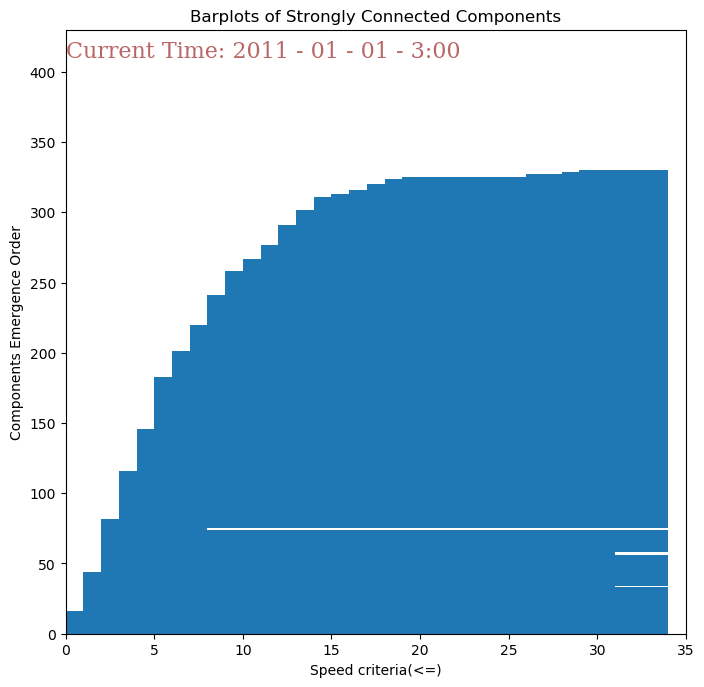

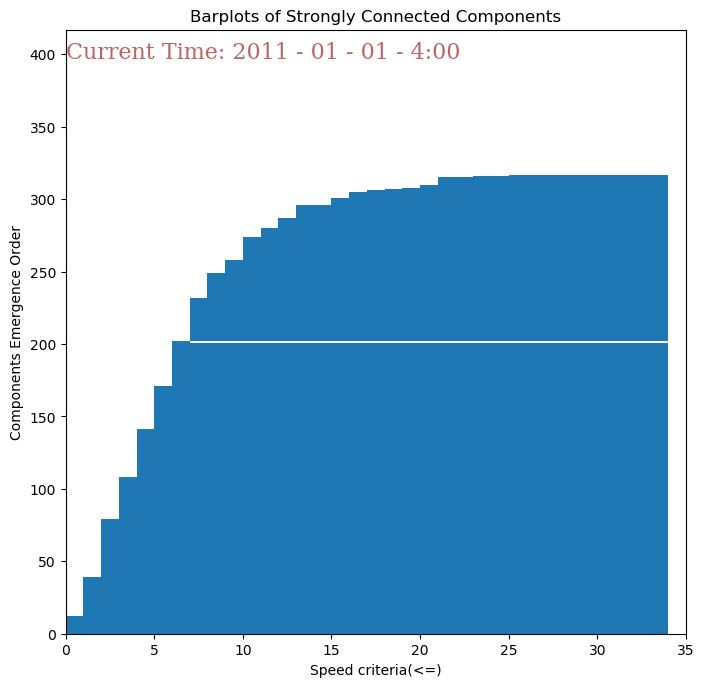

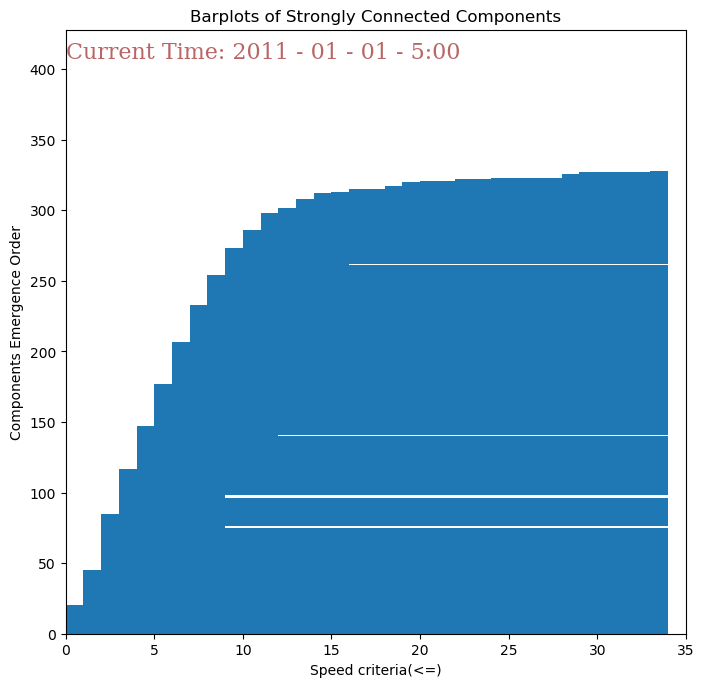

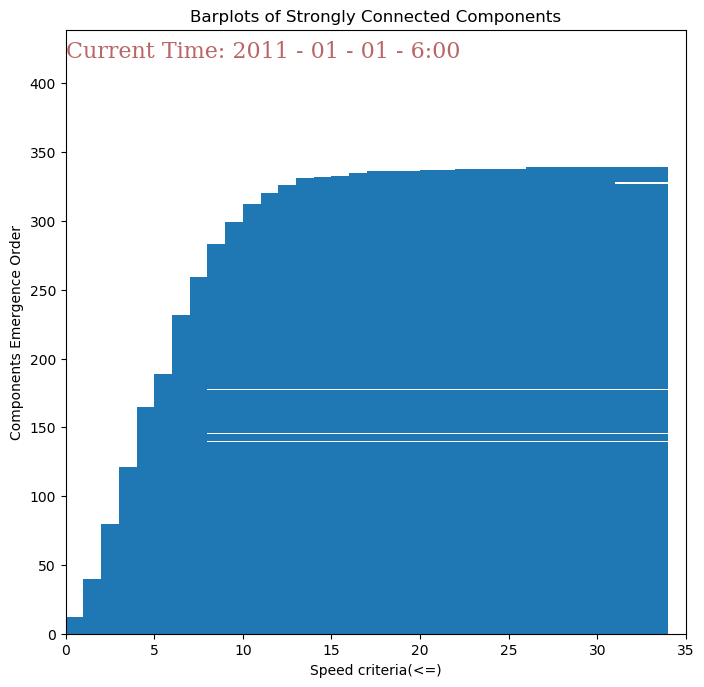

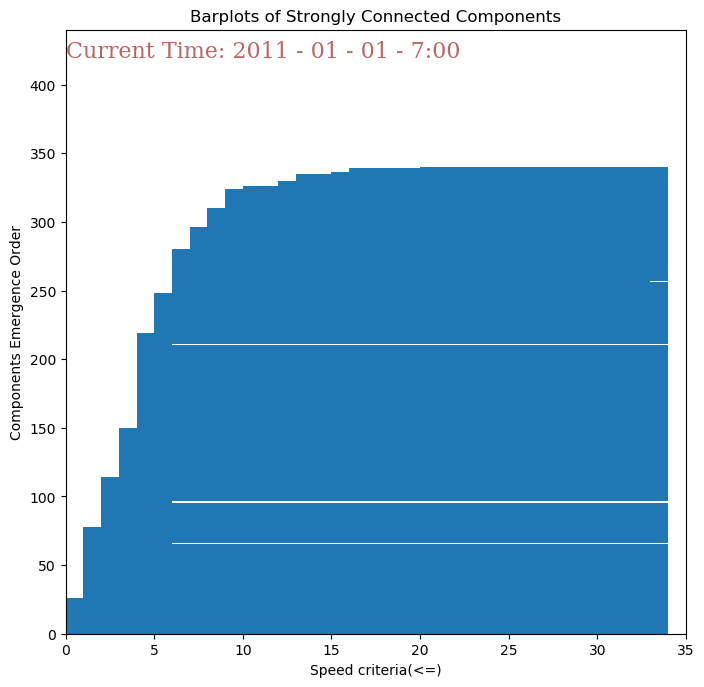

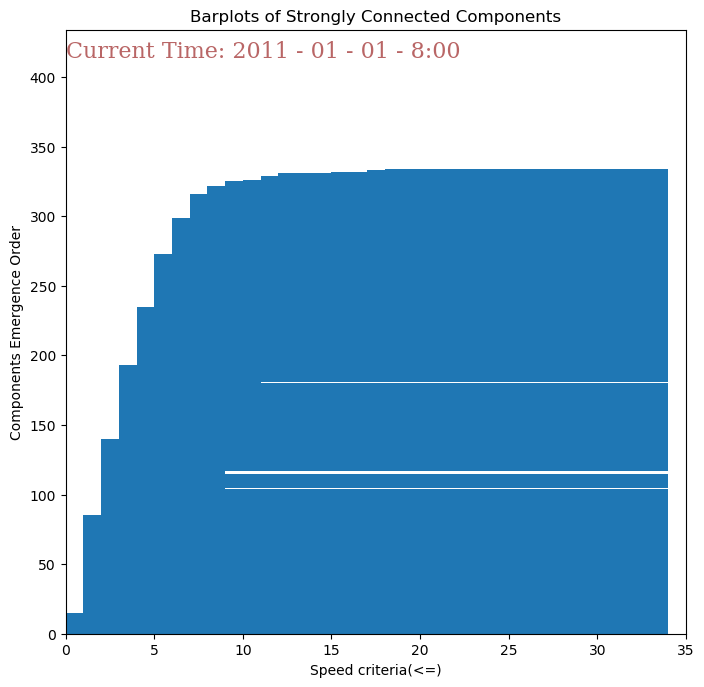

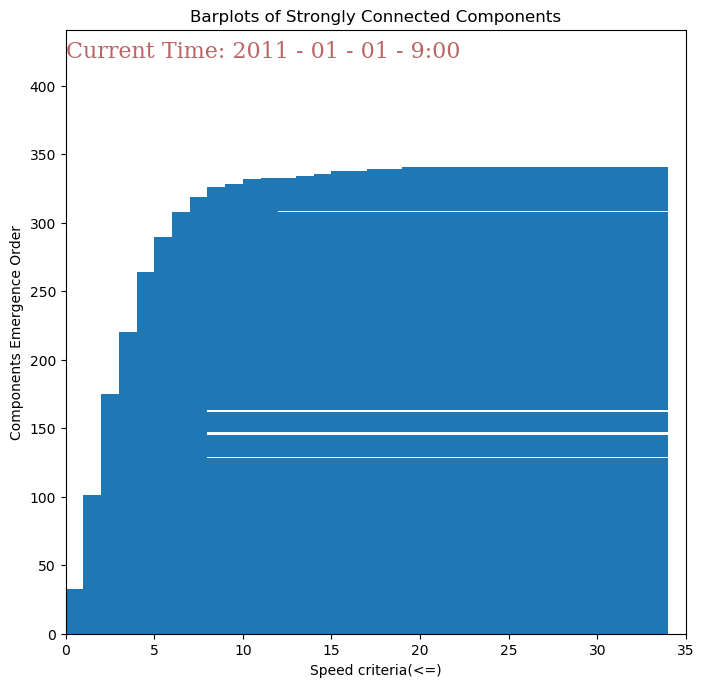

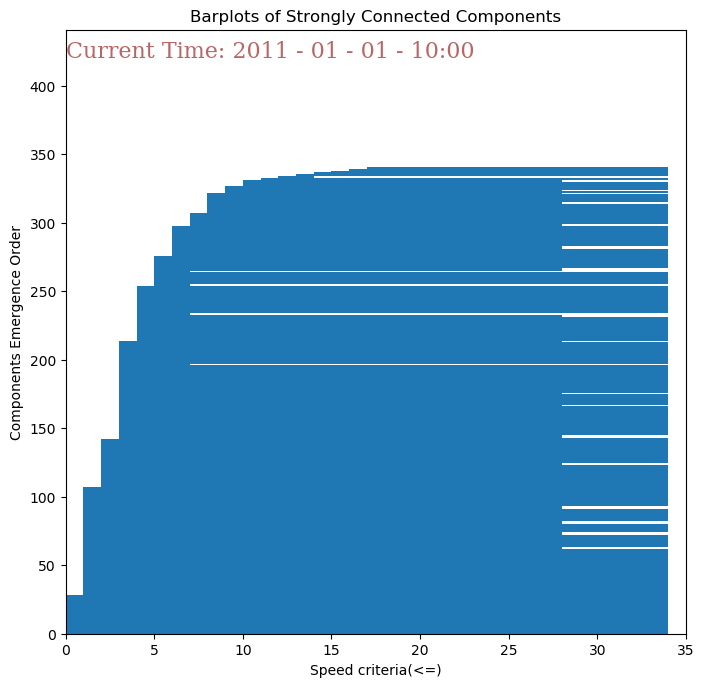

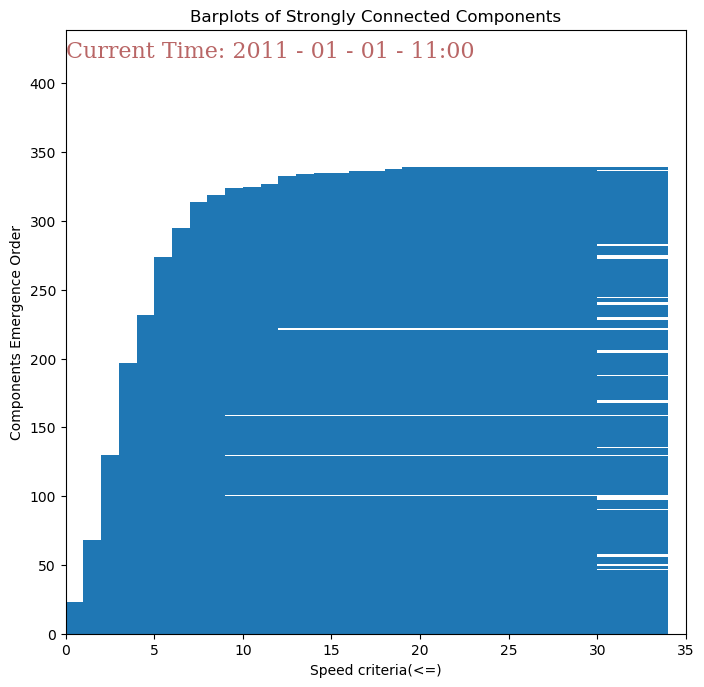

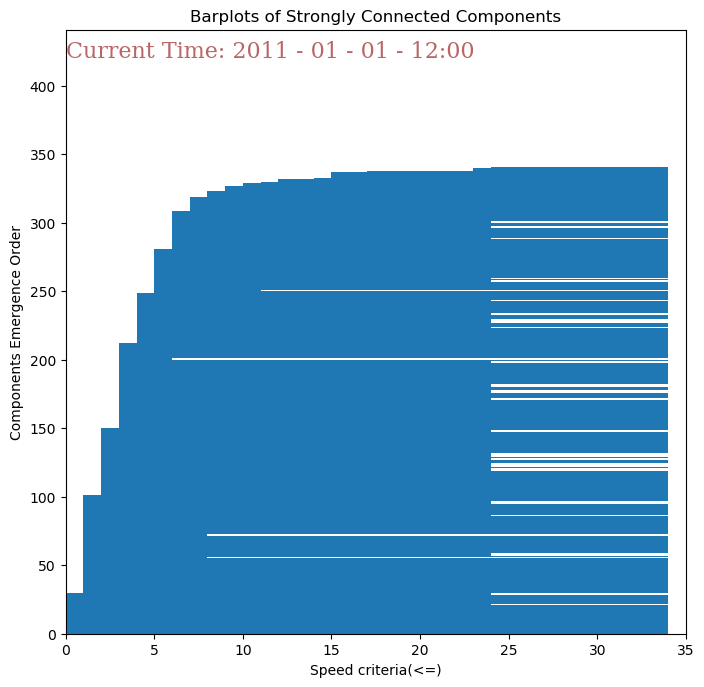

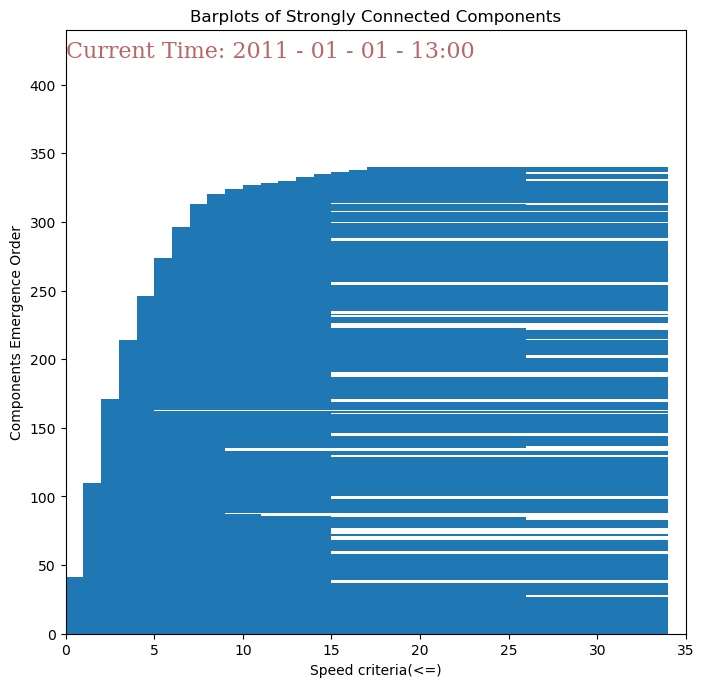

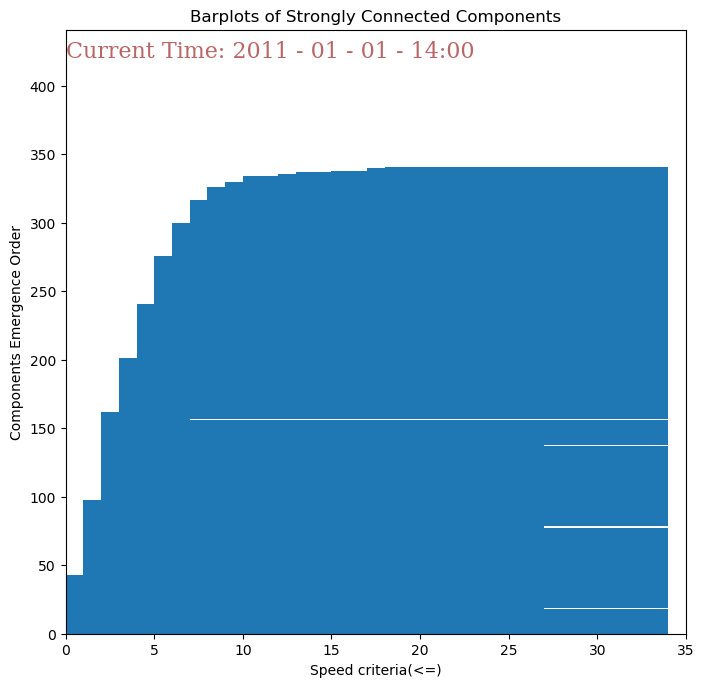

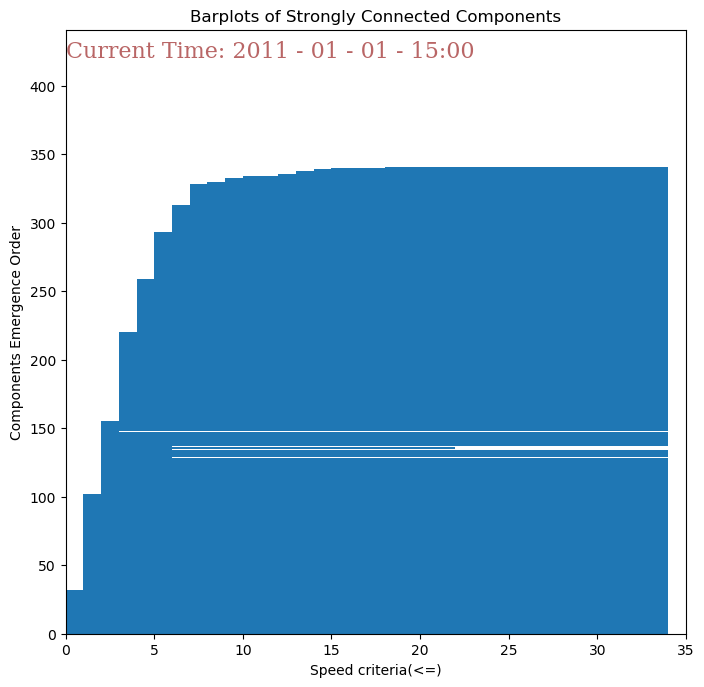

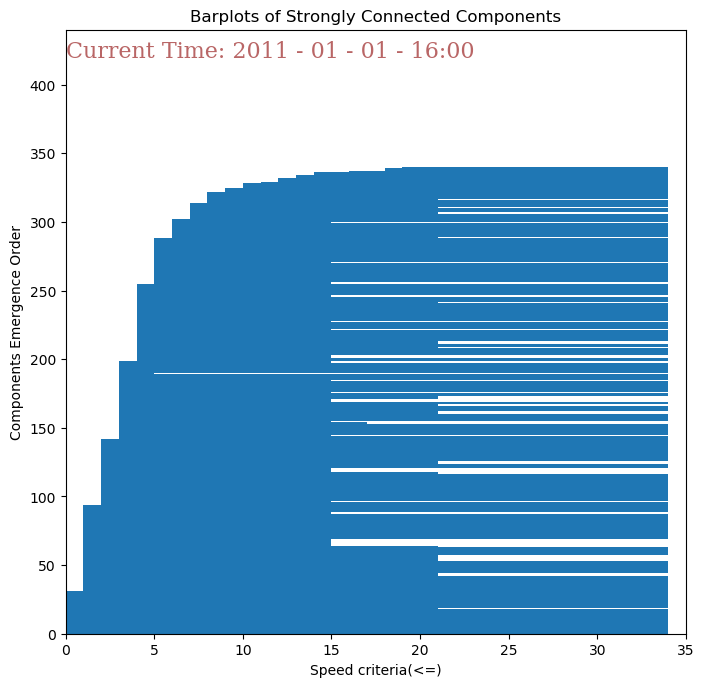

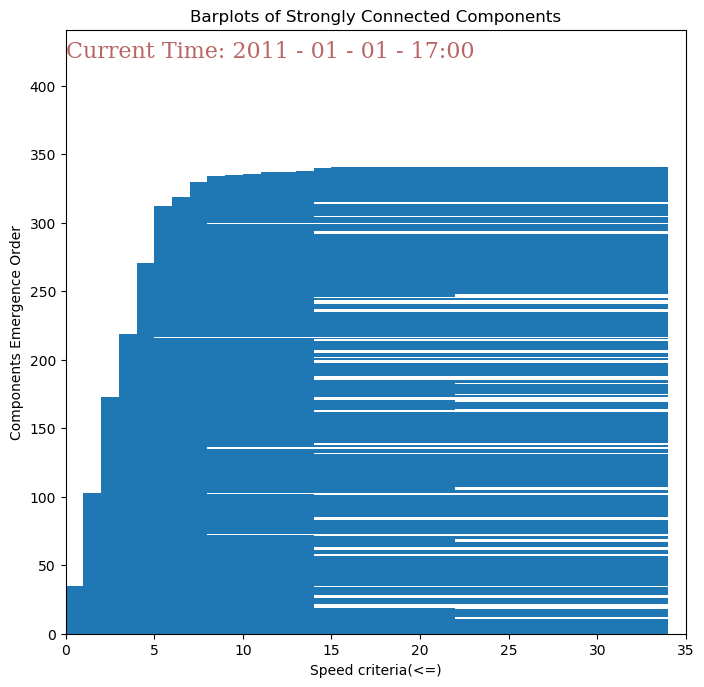

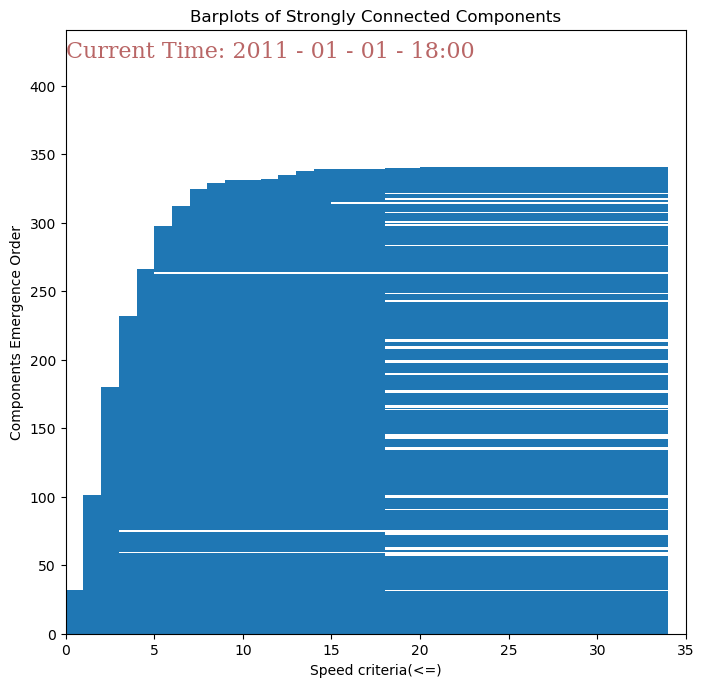

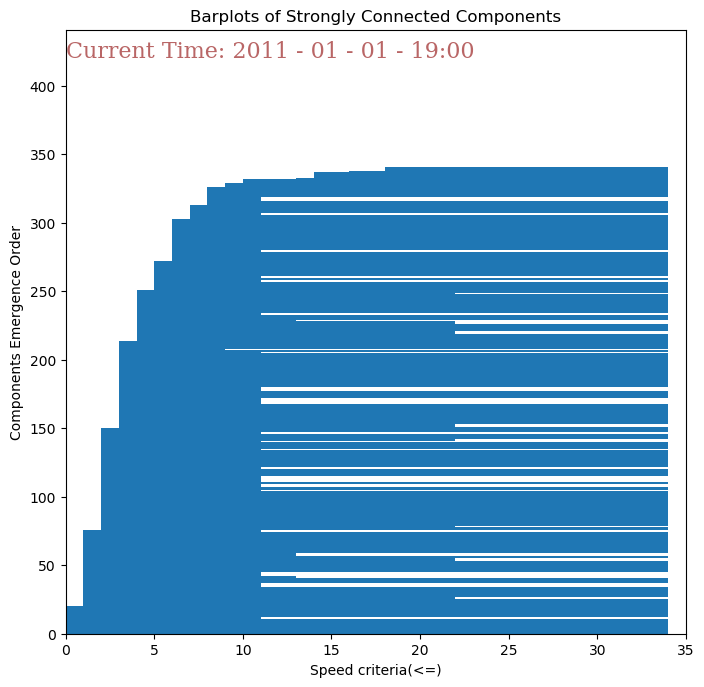

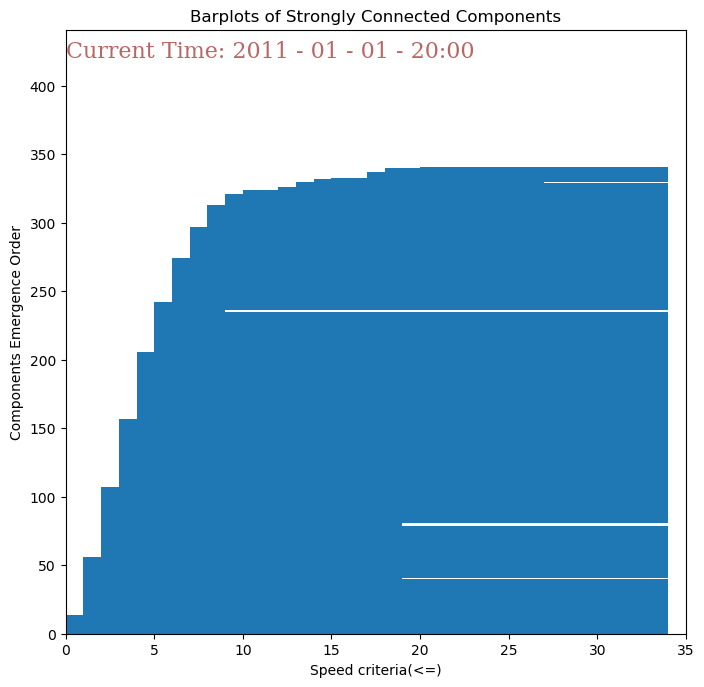

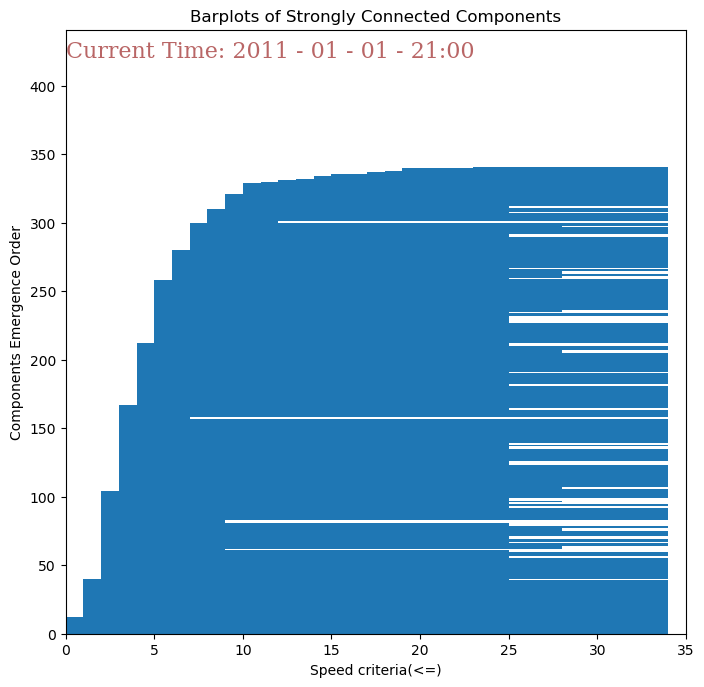

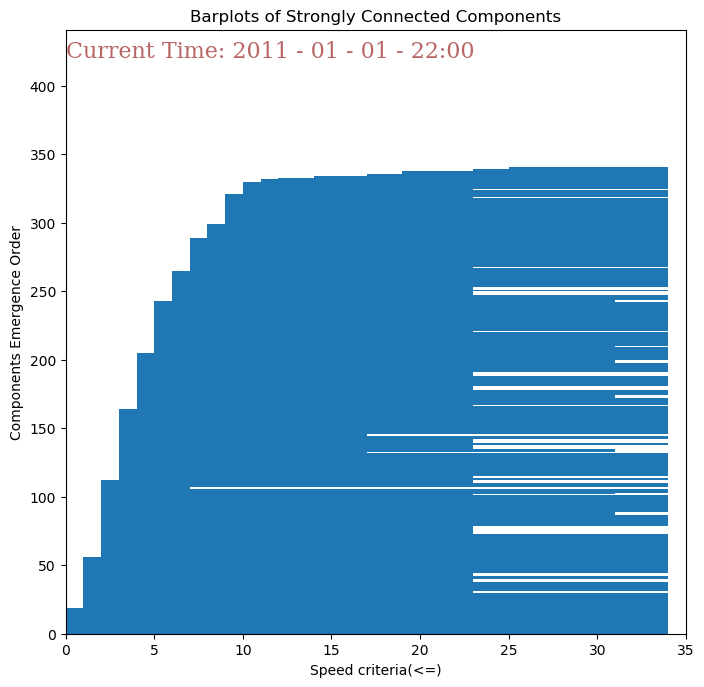

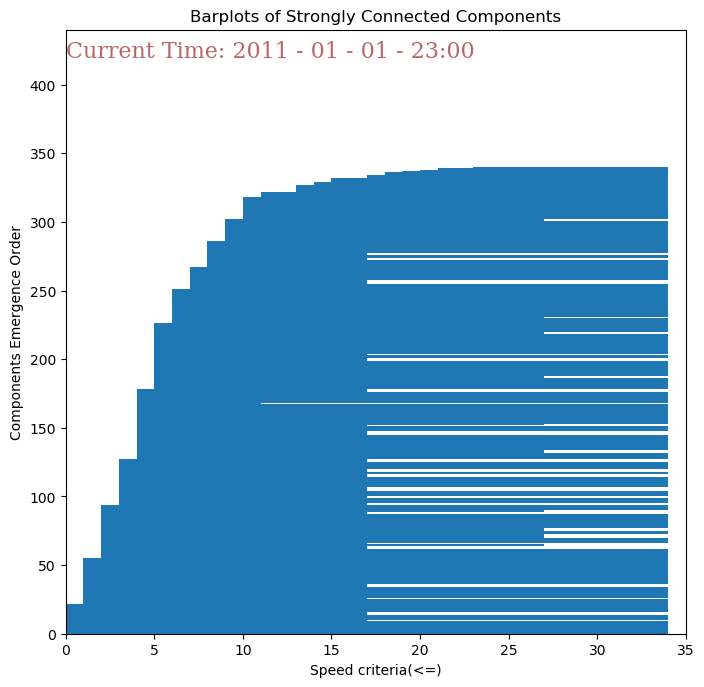

In [43]:
for t in range(24):
    clinkslists = []
    cCompLists = []
    cCompLists_Node = []
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        qualify_links = block_g.filterEdges(lambda e: e.getSpeedAt((numday+1), t) < threshold)
        sub_g = block_g.subgraph(qualify_links)
        cur_scc = sub_g.scc()
        cur_scc_node = sub_g.sccNode()
        cCompLists.append(cur_scc)
        cCompLists_Node.append(cur_scc_node)
        clinkslists.append(reduce(lambda x, y: x+y, cur_scc, []))
        #print("length of scc",len(cur_scc))
        Time_Slices[i].append(len(cur_scc))
    Maxorder, Lifes, Link_to_Order = DrawBarcode(cCompLists_Node, thresholds, t, "scc")
    MaxorderList.append(Maxorder)
    LifeLists.append(Lifes)
    Link_to_Order_List.append(Link_to_Order)